# EDA

## 讀取,轉換字串成可以訓練的資料

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import math

%matplotlib inline
data_path = '../data'

random_seed = 2000

In [2]:
data_list=["raw_data.csv","FE_data1.csv","FE_data2.csv","FE_data3.csv","FE_data4.csv","FE_data4_2.csv","FE_data5.csv",\
            "pca_feature.csv","isolationtree_feature.csv","kmeans_feature.csv"]
data=[]
for d in data_list:
    x = pd.read_csv('../data/preprocess/{}'.format(d))
    print('\n',d,x.shape)
    x_null = x.isnull().sum()
    print("Null columns:\n",x_null[x_null>0])
    
    if (d=='FE_data1.csv') or (d=='FE_data2.csv'):
        x.fillna(value=-1,inplace=True)
        
    data.append(x)

all_data = pd.concat(data,axis=1)

all_data_numsum = all_data.isnull().sum()
print('ALL data null:')
print(all_data_numsum[all_data_numsum>0])


 raw_data.csv (1943452, 23)
Null columns:
 fraud_ind    421665
dtype: int64

 FE_data1.csv (1943452, 56)
Null columns:
 cano_conam_skew      92612
cano_conam_kurt     155720
cano_conam_var       38678
bacno_locdt_skew     58303
bacno_locdt_kurt    101191
cano_locdt_skew      92612
cano_locdt_kurt     155720
dtype: int64

 FE_data2.csv (1943452, 30)
Null columns:
 Series([], dtype: int64)

 FE_data3.csv (1943452, 9)
Null columns:
 Series([], dtype: int64)

 FE_data4.csv (1943452, 4)
Null columns:
 Series([], dtype: int64)

 FE_data4_2.csv (1943452, 6)
Null columns:
 Series([], dtype: int64)

 FE_data5.csv (1943452, 4)
Null columns:
 Series([], dtype: int64)

 pca_feature.csv (1943452, 5)
Null columns:
 Series([], dtype: int64)

 isolationtree_feature.csv (1943452, 4)
Null columns:
 Series([], dtype: int64)

 kmeans_feature.csv (1943452, 5)
Null columns:
 Series([], dtype: int64)
ALL data null:
fraud_ind    421665
dtype: int64


In [3]:
bool_cols = all_data.columns[all_data.dtypes==bool].values
for b in bool_cols:
    all_data[b] = all_data[b].map({True:1,False:0}) 

## EDA(觀察資料分佈, 找特徵工程的Idea）

#### 方法（四種）:
1. 比較train, validation data, test data各個feature(不包括fraud_ind)的分佈，看各個feature是否會隨時間不同而改變
    * 見 function compare_distribution
    * 檢查差異,目測結果: txkey有一點差異，其他幾乎一樣
    

2. 比較train, validation data各個feature相對於fraud_ind的關係，看他們與fraud_ind的關係是否會隨時間改變，如果會就不適合做training feature
    * 見 function analze_distribution
    * 檢查差異，目測結果:
        * 明顯差異,應該去除,或應該抽取更高層的穩定特徵(TODO): csmcu,mcc,loctm_hr2
        * 無法判讀:應該找出來並想辦法去除或找更高層特徵(TODO): 蠻多特徵都看不出來有沒有差,因為類別太多＝＝


3. 比較normal, fraud data的各個feature分佈差異，找有問題的feature!
    * 結果:


4. 但這樣無法看出單一用戶在normal和fraud的關係，所以要另外印出檢查，看有fraud data的用戶，該資料特點在哪
    * 根據時間順序,以每個bacno來看fraud情況(最重要,適合找data leakage!!!!)
    

## 觀測 train, validation, test的distribution
* 跟fraud_ind相關的，檢查train和validation就好（假設test data跟validation類似）
* 每筆feature的distribution，檢查train,validation和test


In [4]:
def analze_distribution(data, target_col, feature, data_test):
#     if data[feature].nunique()!=data_test[feature].nunique():
#         print('data nunique not the same')
    print(feature)
    plt.clf()
    mean_data = data.groupby(feature)[target_col].mean()
    mean_data_test = data_test.groupby(feature)[target_col].mean()
    distribution_data = data[feature].value_counts(dropna=False)
    distribution_data_test = data_test[feature].value_counts(dropna=False)
    
    fig, axs = plt.subplots(2,2,figsize=(10,5))
    axs[0,0].plot(mean_data.index, mean_data.values, marker='o')
    axs[0,0].set_title('Average {} wrt {}'.format(target_col,feature))
    axs[0,0].set_ylabel('mean of {}'.format(target_col))
    axs[0,0].set_xlabel(feature)
    
    
    bins = data[feature].nunique() if data[feature].nunique()<100 else 100
    data[feature].hist(bins=bins,ax=axs[0,1])

#     axs[0,1].bar(distribution_data.index, distribution_data.values, alpha=0.5)
    axs[0,1].set_title('distribution of {}'.format(feature))
    axs[0,1].set_ylabel('count of {}'.format(feature))
    axs[0,1].set_xlabel(feature)
    
    # Add text in figure coordinates
    plt.figtext(0.5, 1,   'Train data plot', ha='center', va='center', fontsize=15)
    plt.figtext(0.5, 0.5, 'Test data plot', ha='center', va='center', fontsize=15)
    axs[1,0].plot(mean_data_test.index, mean_data_test.values, marker='o')
    axs[1,0].set_title('Average {} wrt {}'.format(target_col,feature))
    axs[1,0].set_ylabel('mean of {}'.format(target_col))
    axs[1,0].set_xlabel(feature)
    
    bins = data_test[feature].nunique() if data_test[feature].nunique()<100 else 100
    data_test[feature].hist(bins=bins,ax=axs[1,1])
#     axs[1,1].bar(distribution_data_test.index, distribution_data_test.values, alpha=0.5)
    distribution_data_test.hist
    axs[1,1].set_title('distribution of {}'.format(feature))
    axs[1,1].set_ylabel('count of {}'.format(feature))
    axs[1,1].set_xlabel(feature)
    plt.tight_layout(pad=3)
    plt.show()

acqic


<Figure size 432x288 with 0 Axes>

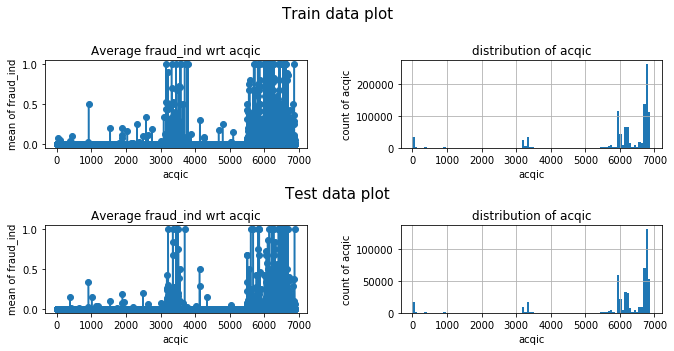

bacno


<Figure size 432x288 with 0 Axes>

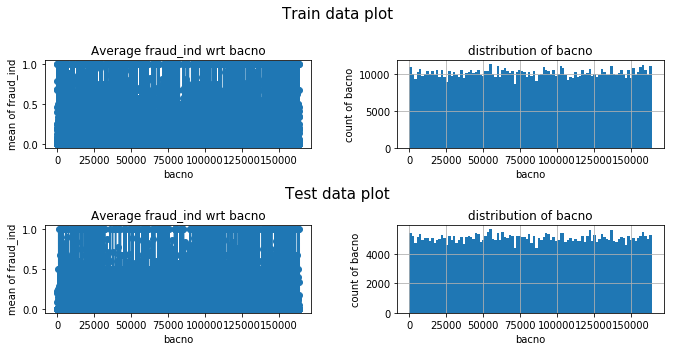

cano


<Figure size 432x288 with 0 Axes>

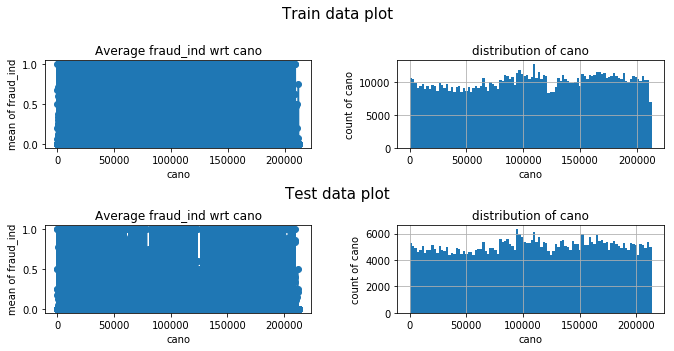

conam


<Figure size 432x288 with 0 Axes>

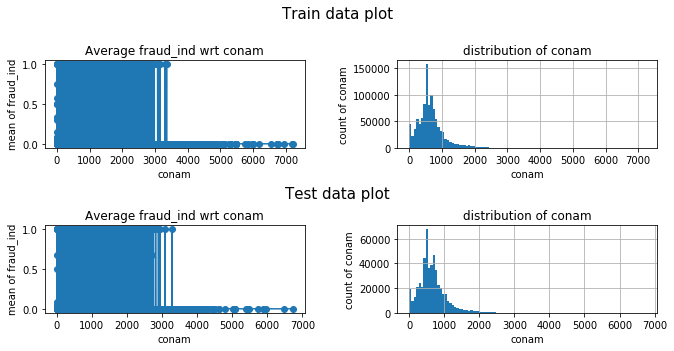

contp


<Figure size 432x288 with 0 Axes>

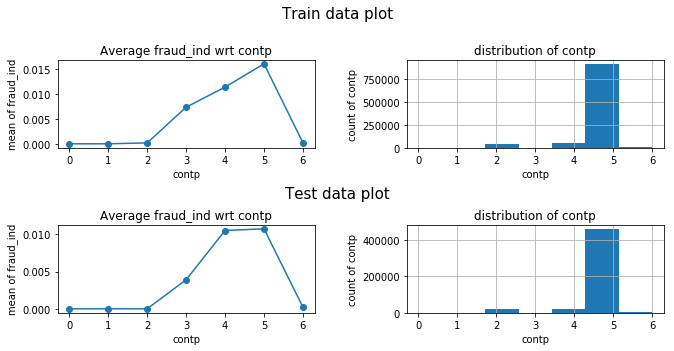

csmcu


<Figure size 432x288 with 0 Axes>

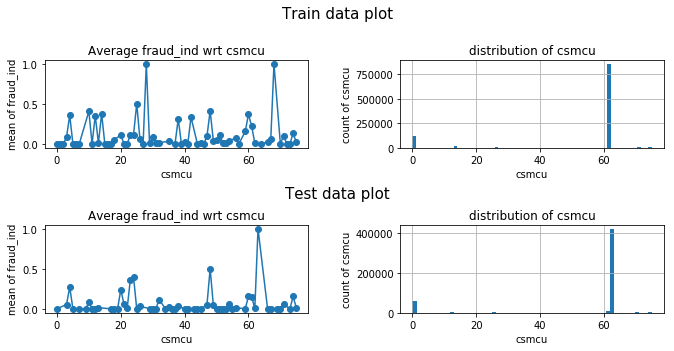

ecfg


<Figure size 432x288 with 0 Axes>

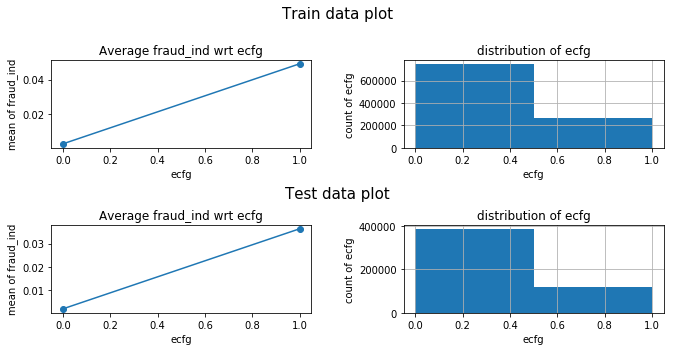

etymd


<Figure size 432x288 with 0 Axes>

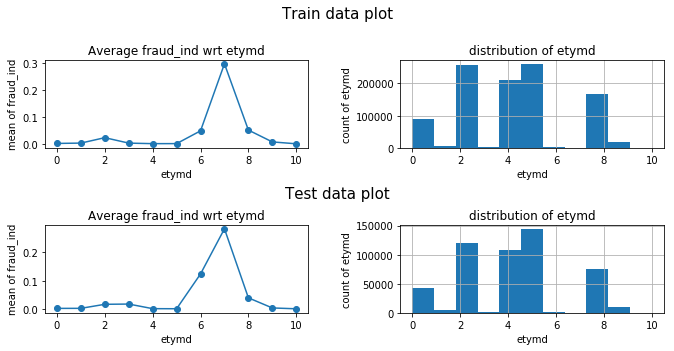

flbmk


<Figure size 432x288 with 0 Axes>

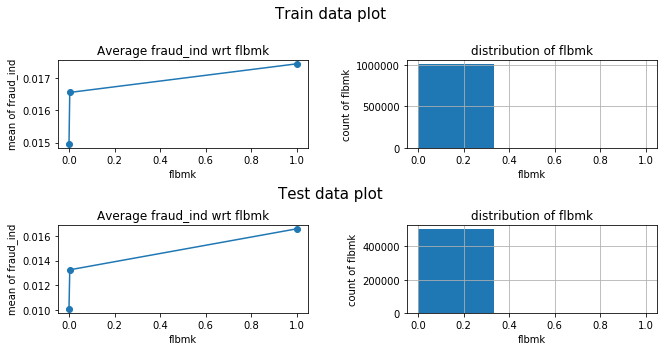

flg_3dsmk


<Figure size 432x288 with 0 Axes>

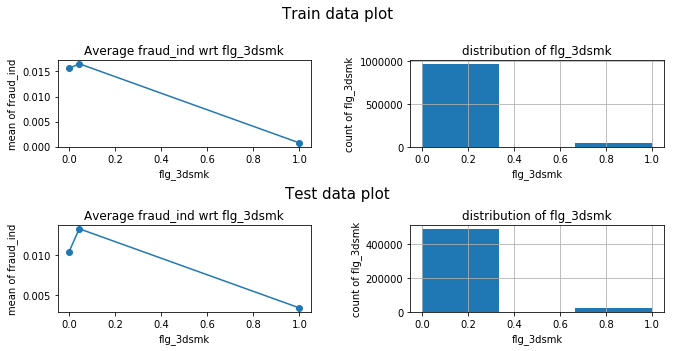

fraud_ind


<Figure size 432x288 with 0 Axes>

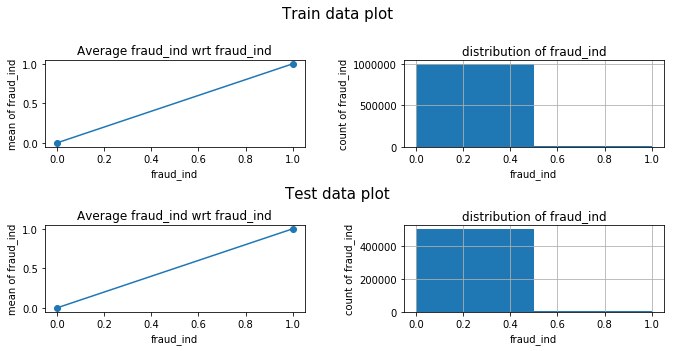

hcefg


<Figure size 432x288 with 0 Axes>

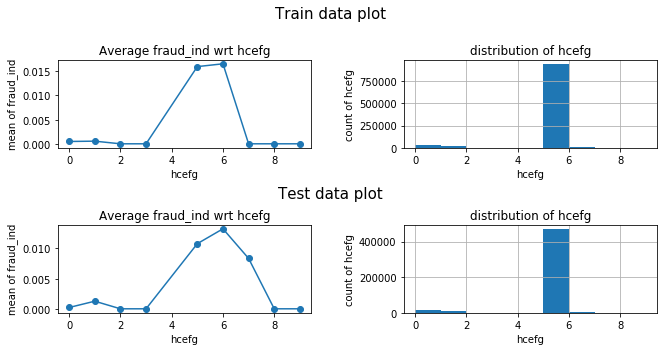

insfg


<Figure size 432x288 with 0 Axes>

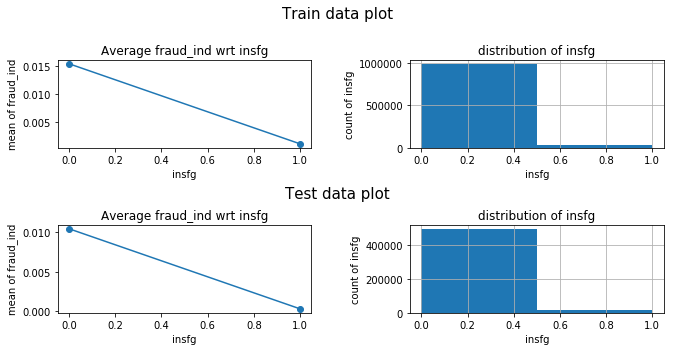

iterm


<Figure size 432x288 with 0 Axes>

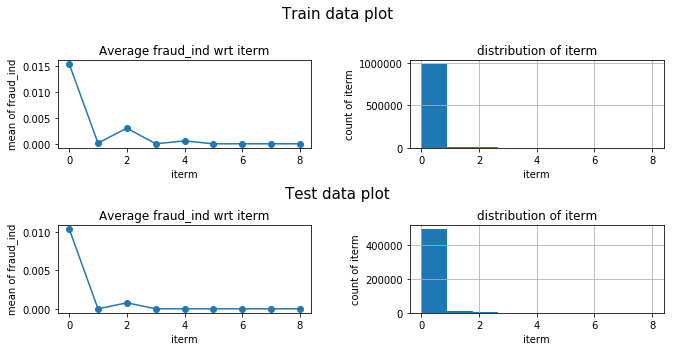

locdt


<Figure size 432x288 with 0 Axes>

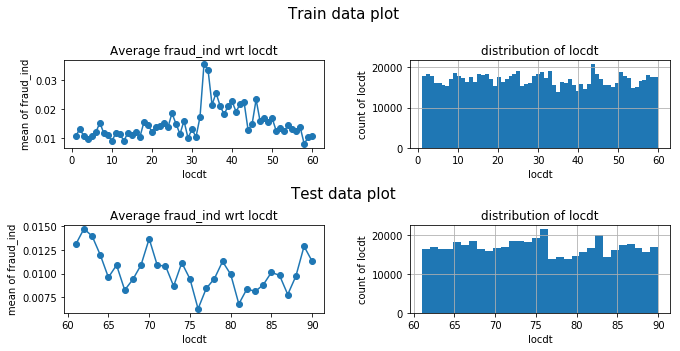

loctm


<Figure size 432x288 with 0 Axes>

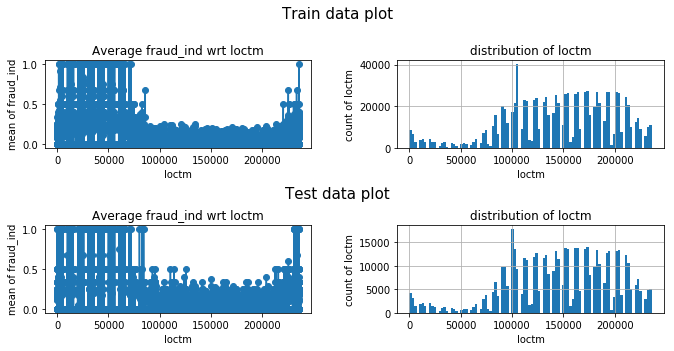

mcc


<Figure size 432x288 with 0 Axes>

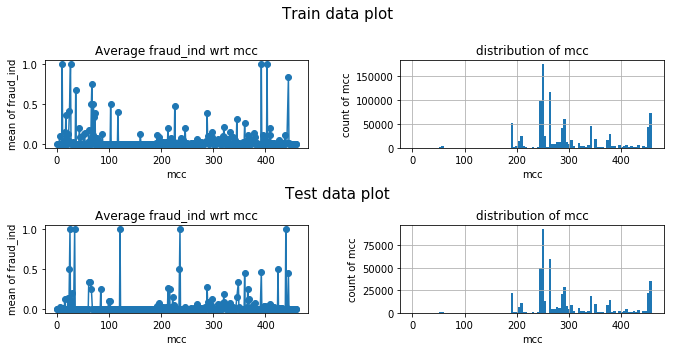

mchno


<Figure size 432x288 with 0 Axes>

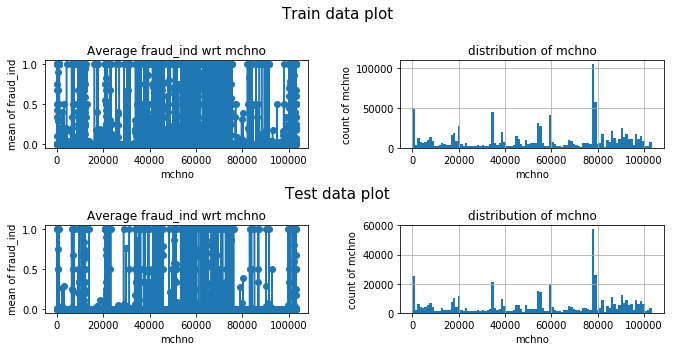

ovrlt


<Figure size 432x288 with 0 Axes>

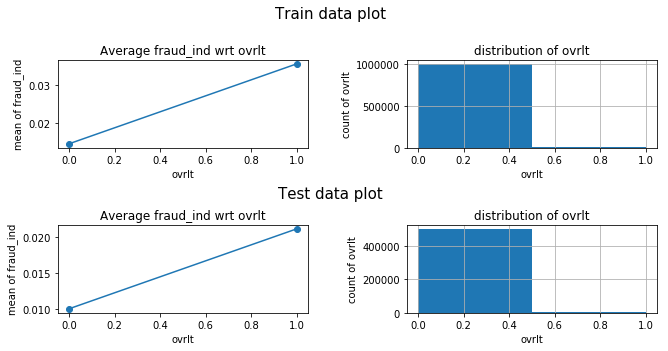

scity


<Figure size 432x288 with 0 Axes>

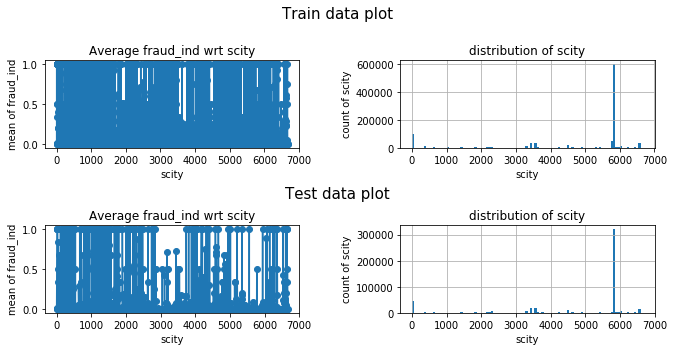

stocn


<Figure size 432x288 with 0 Axes>

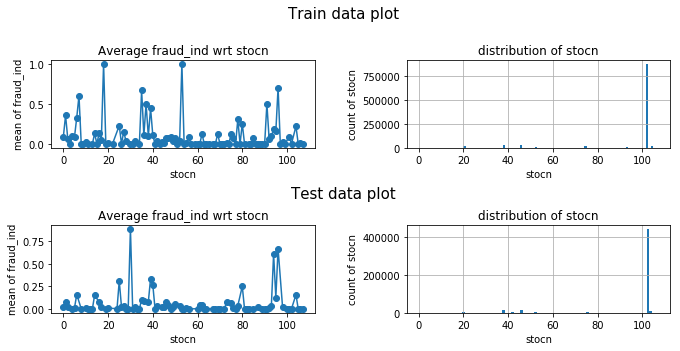

stscd


<Figure size 432x288 with 0 Axes>

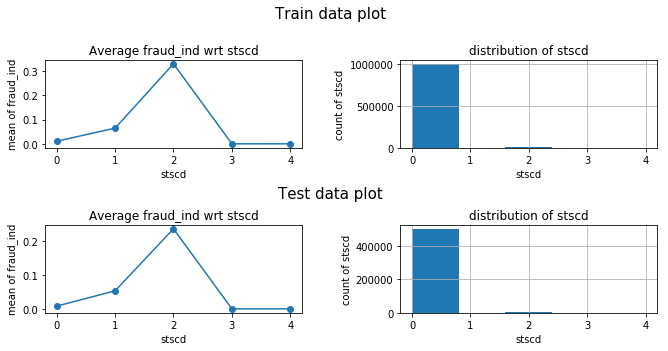

txkey


<Figure size 432x288 with 0 Axes>

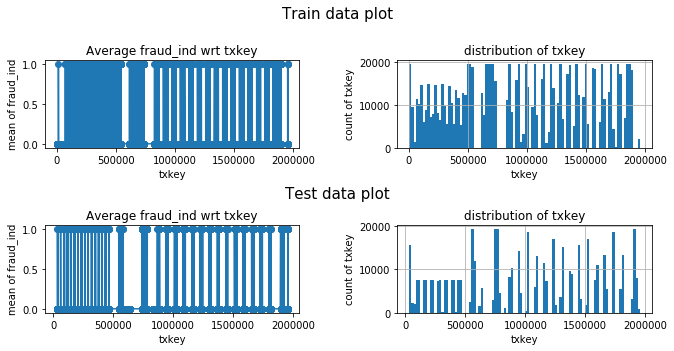

bacno_cano_nunique


<Figure size 432x288 with 0 Axes>

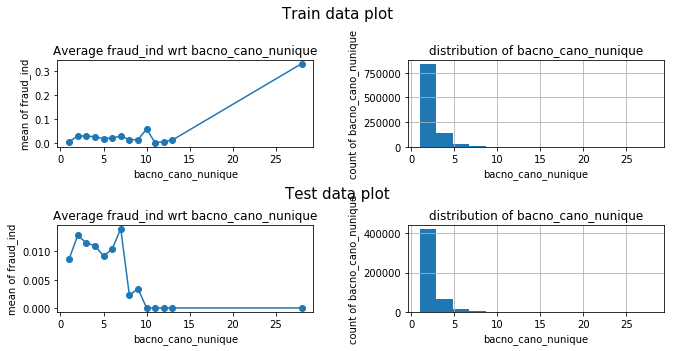

bacno_txkey_nunique


<Figure size 432x288 with 0 Axes>

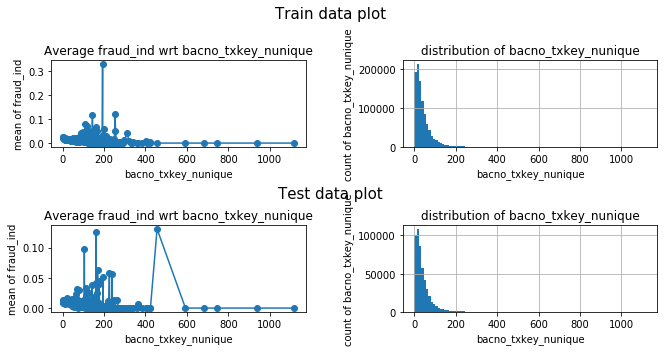

conam_log


<Figure size 432x288 with 0 Axes>

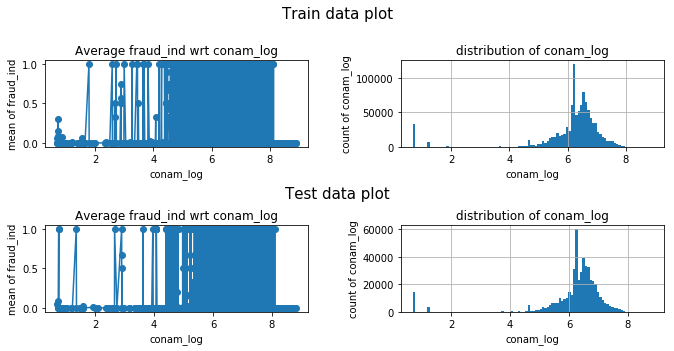

bacno_mean_conam


<Figure size 432x288 with 0 Axes>

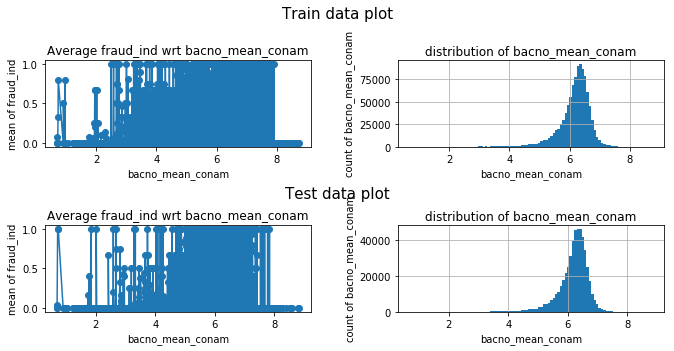

bacno_scale_conam


<Figure size 432x288 with 0 Axes>

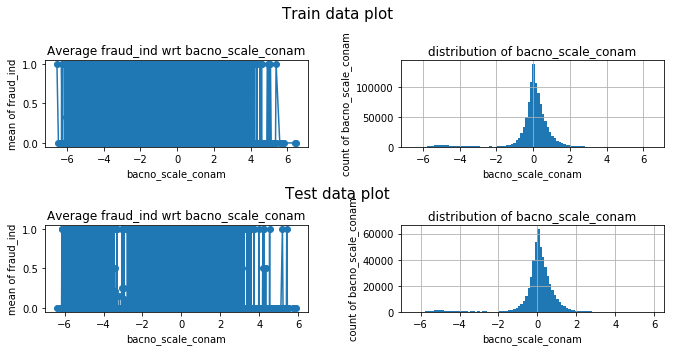

cano_mean_conam


<Figure size 432x288 with 0 Axes>

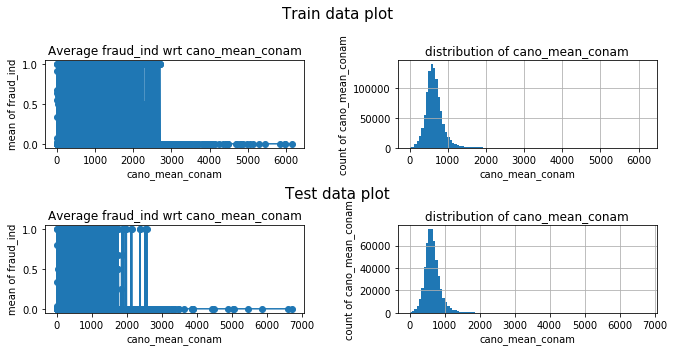

cano_scale_conam


<Figure size 432x288 with 0 Axes>

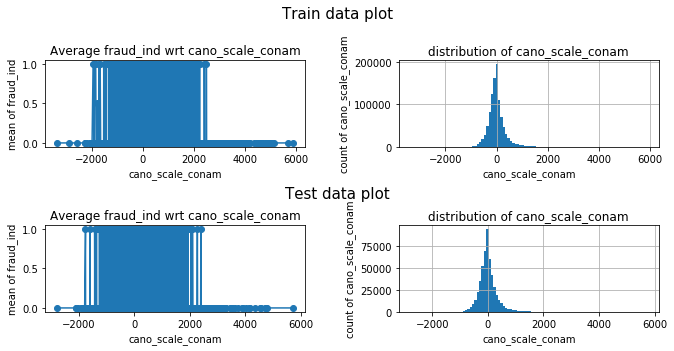

cano_conam_skew


<Figure size 432x288 with 0 Axes>

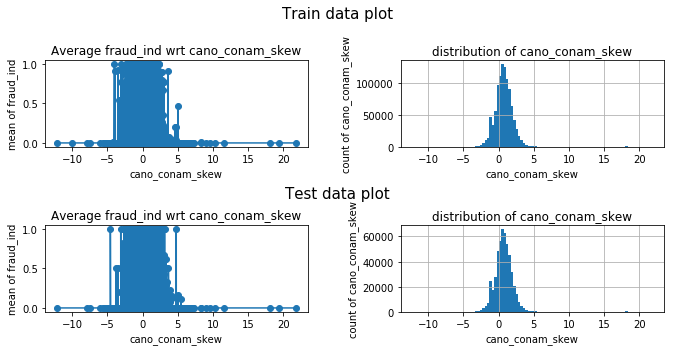

cano_conam_kurt


<Figure size 432x288 with 0 Axes>

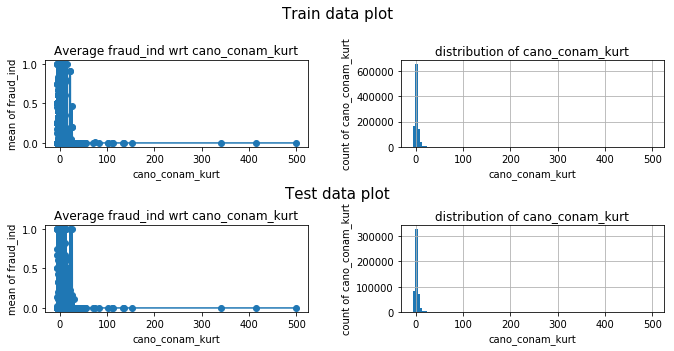

cano_conam_mean


<Figure size 432x288 with 0 Axes>

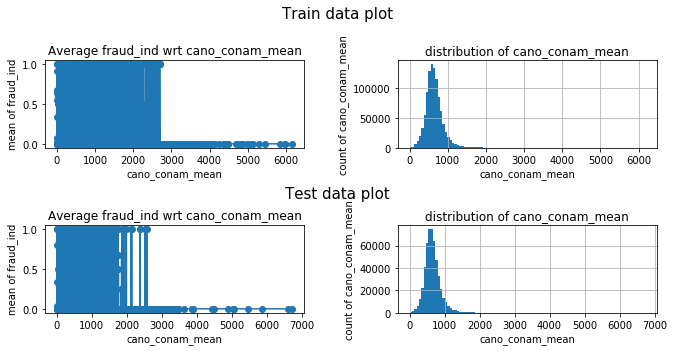

cano_conam_var


<Figure size 432x288 with 0 Axes>

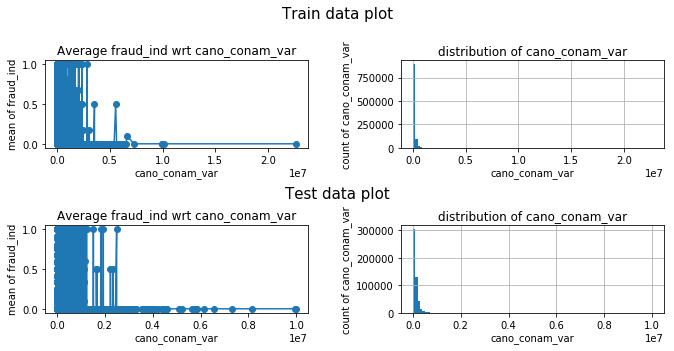

bacno_max_conam


<Figure size 432x288 with 0 Axes>

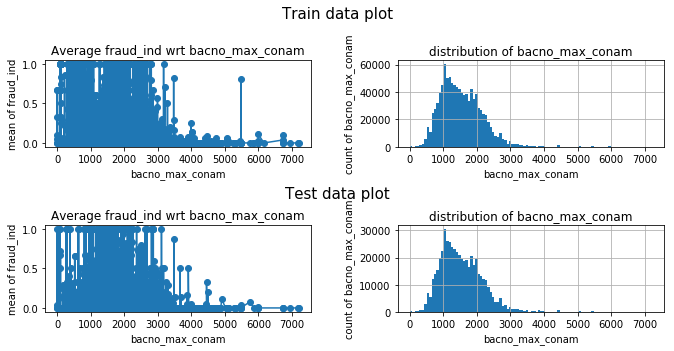

bacno_ismax_conam


<Figure size 432x288 with 0 Axes>

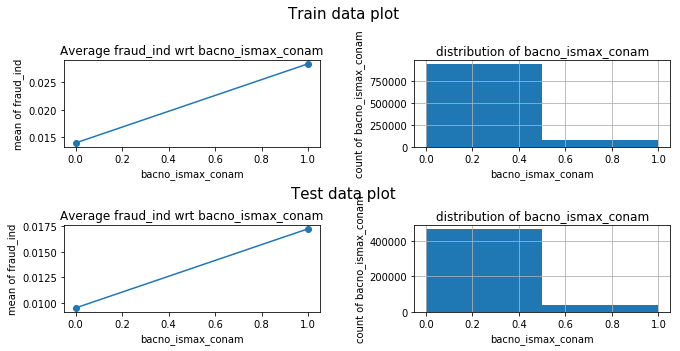

bacno_min_conam


<Figure size 432x288 with 0 Axes>

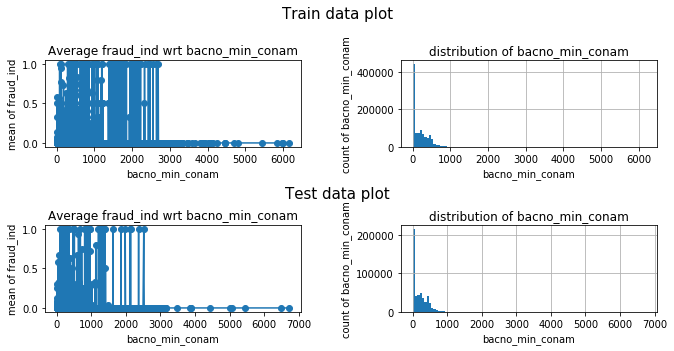

bacno_ismin_conam


<Figure size 432x288 with 0 Axes>

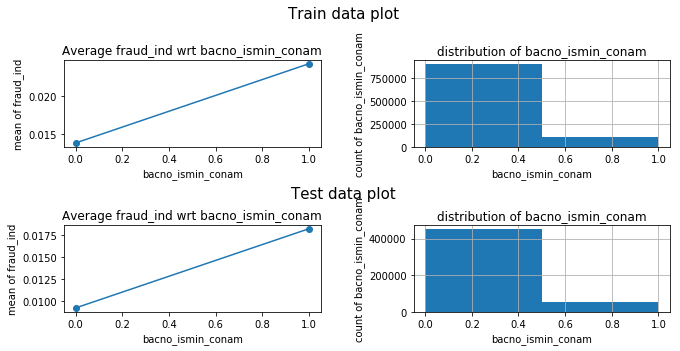

bacno_ratio_ecfg


<Figure size 432x288 with 0 Axes>

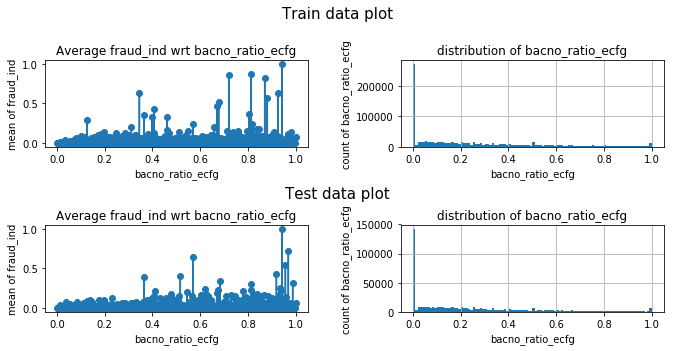

cano_ratio_ecfg


<Figure size 432x288 with 0 Axes>

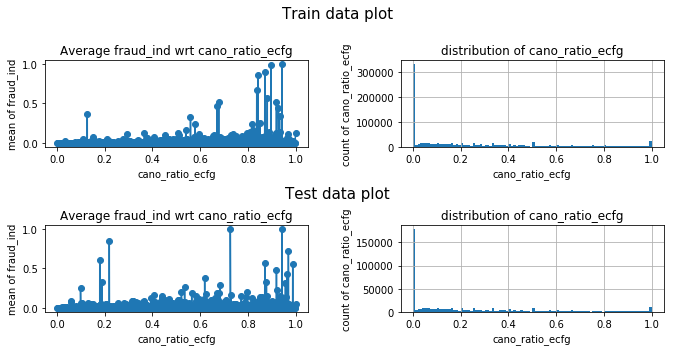

locdt_week


<Figure size 432x288 with 0 Axes>

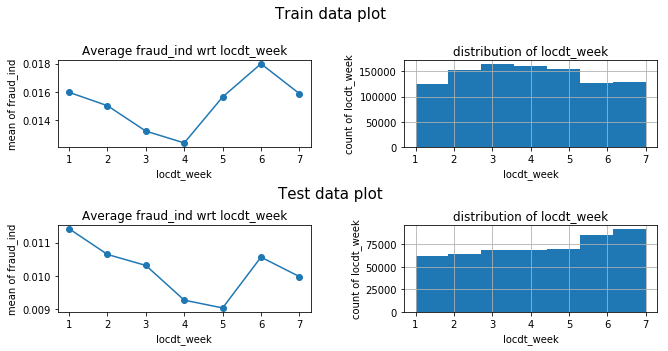

loctm_hr


<Figure size 432x288 with 0 Axes>

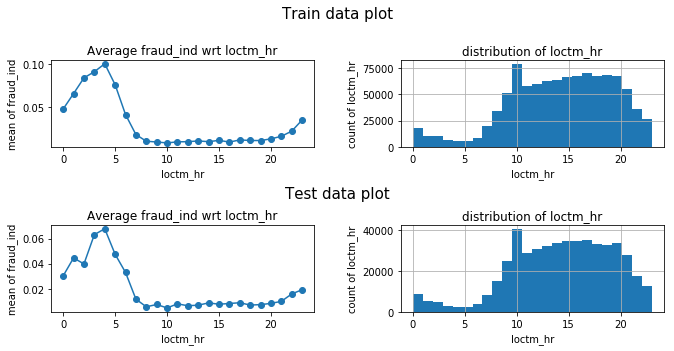

bacno_locdt_skew


<Figure size 432x288 with 0 Axes>

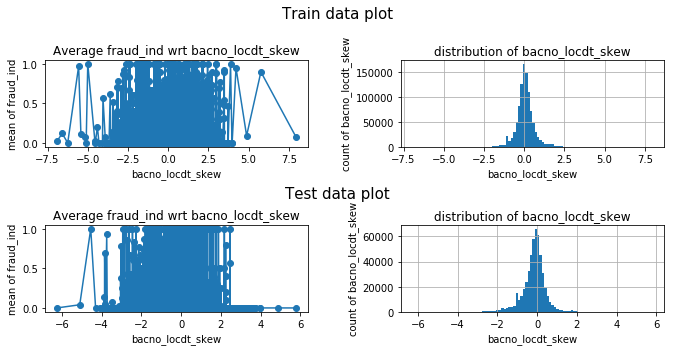

bacno_locdt_kurt


<Figure size 432x288 with 0 Axes>

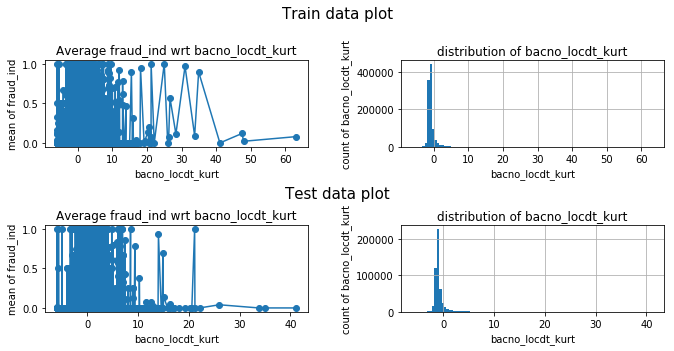

cano_locdt_skew


<Figure size 432x288 with 0 Axes>

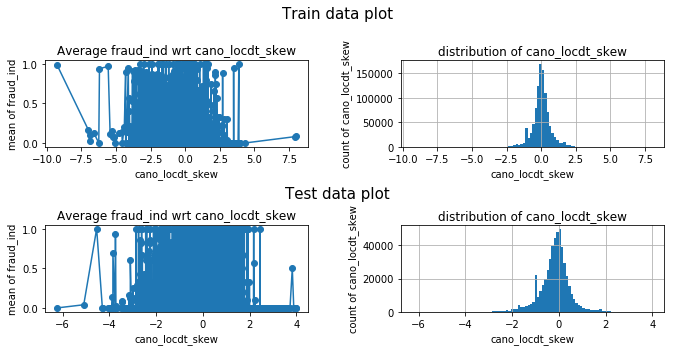

cano_locdt_kurt


<Figure size 432x288 with 0 Axes>

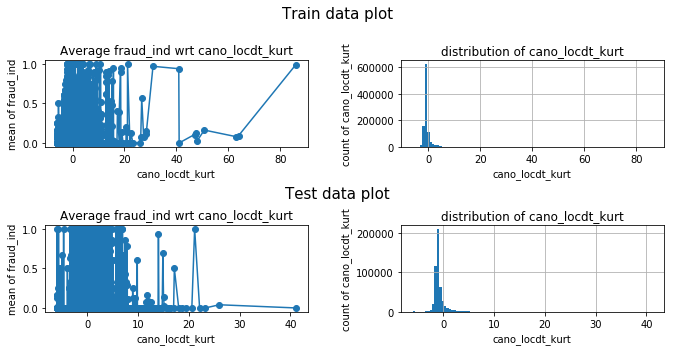

bacno_stocn_mode


<Figure size 432x288 with 0 Axes>

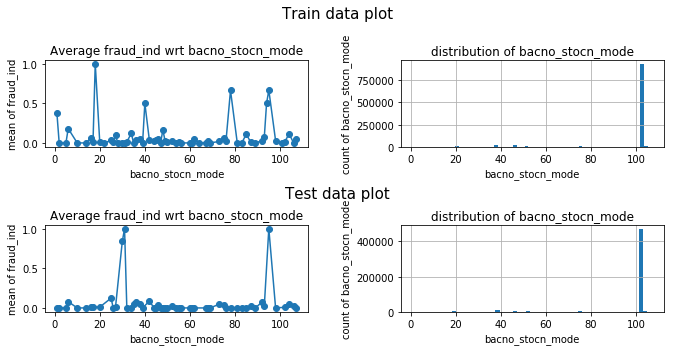

bacno_scity_mode


<Figure size 432x288 with 0 Axes>

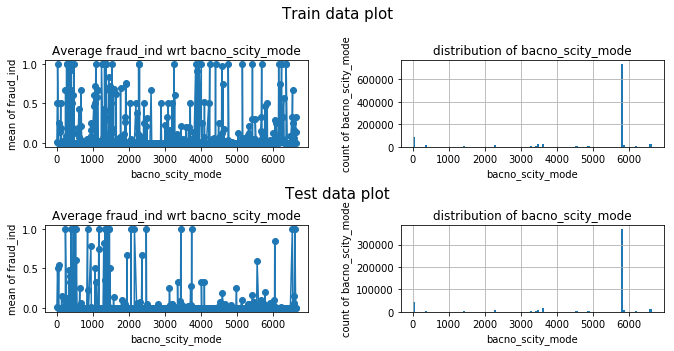

bacno_csmcu_mode


<Figure size 432x288 with 0 Axes>

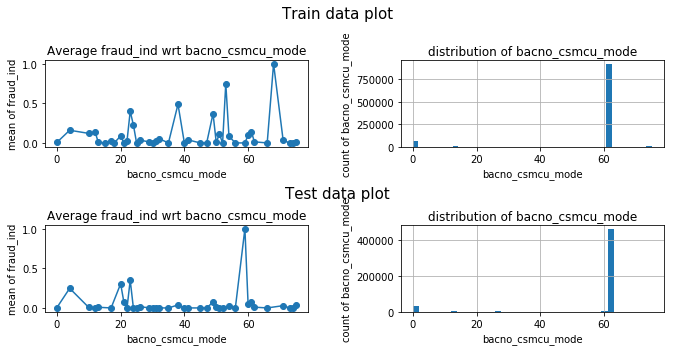

bacno_stocn_ismode


<Figure size 432x288 with 0 Axes>

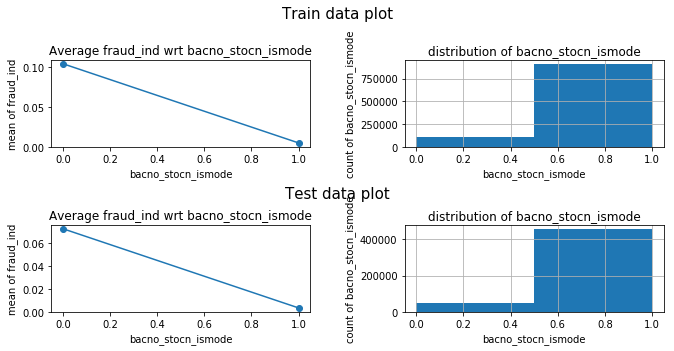

bacno_scity_ismode


<Figure size 432x288 with 0 Axes>

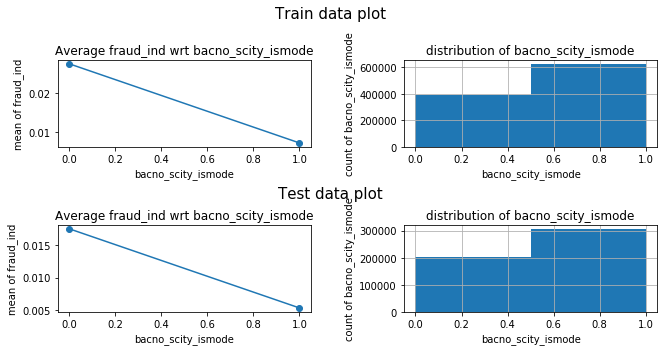

bacno_csmcu_ismode


<Figure size 432x288 with 0 Axes>

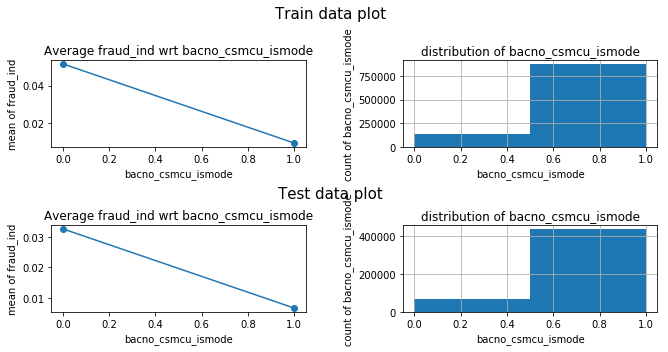

cano_stocn_mode


<Figure size 432x288 with 0 Axes>

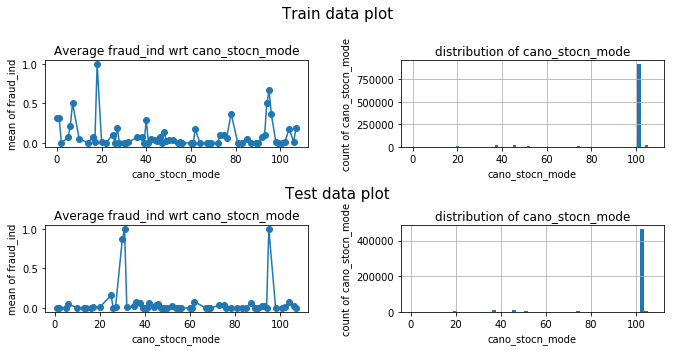

cano_scity_mode


<Figure size 432x288 with 0 Axes>

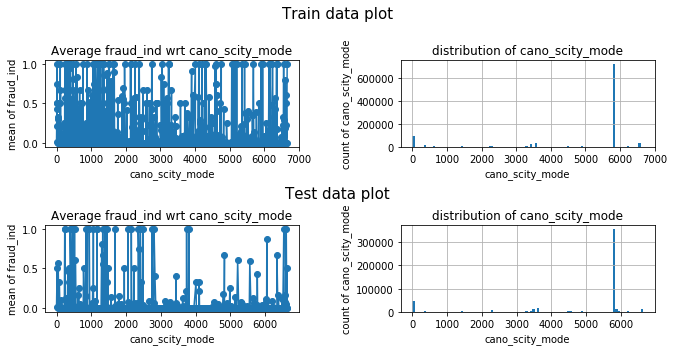

cano_csmcu_mode


<Figure size 432x288 with 0 Axes>

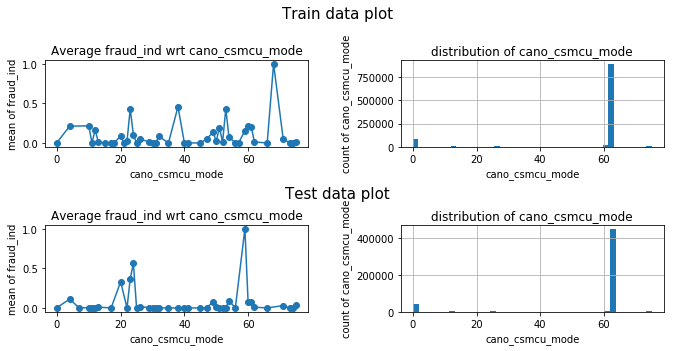

cano_stocn_ismode


<Figure size 432x288 with 0 Axes>

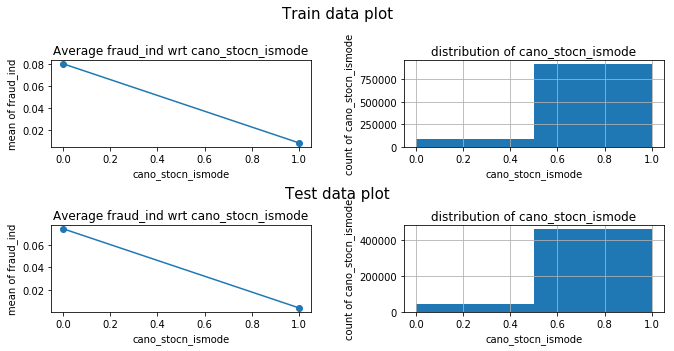

cano_scity_ismode


<Figure size 432x288 with 0 Axes>

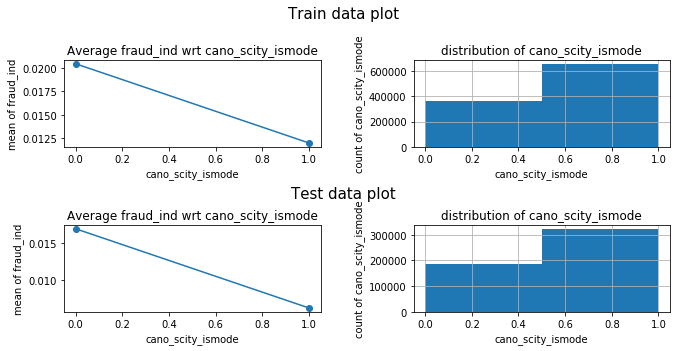

cano_csmcu_ismode


<Figure size 432x288 with 0 Axes>

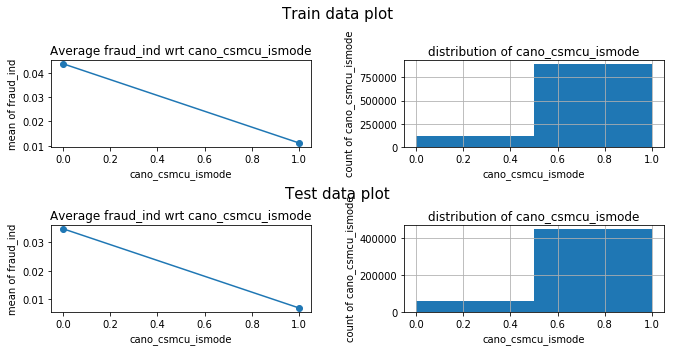

mchno_fraud_mean


<Figure size 432x288 with 0 Axes>

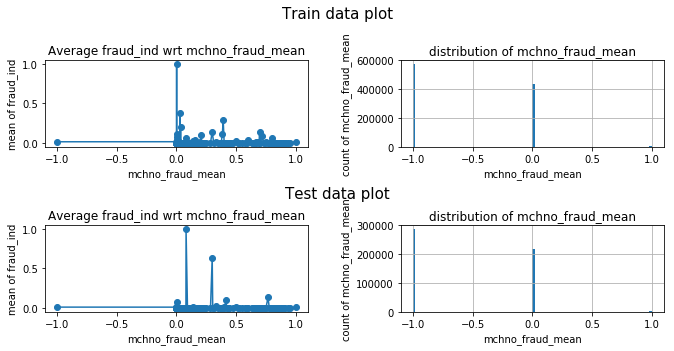

mcc_fraud_mean


<Figure size 432x288 with 0 Axes>

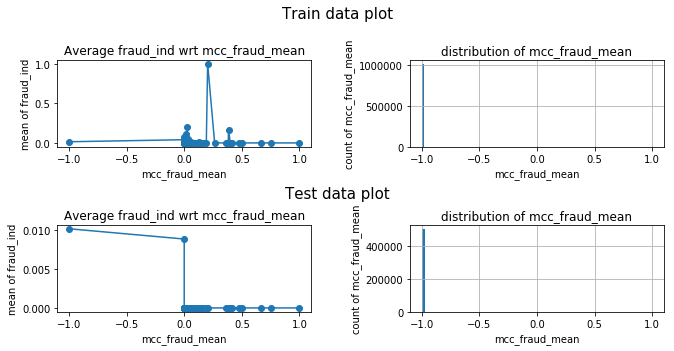

acqic_fraud_mean


<Figure size 432x288 with 0 Axes>

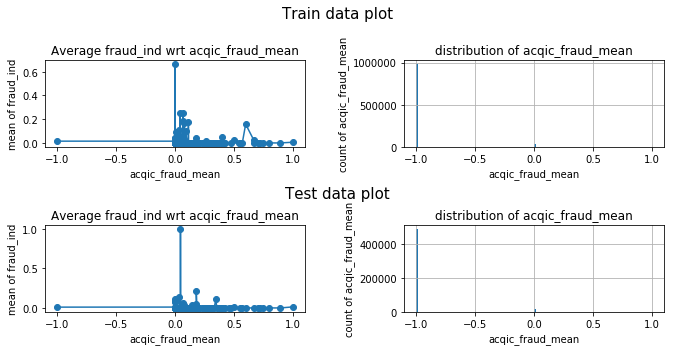

mchno_bacno_nunique


<Figure size 432x288 with 0 Axes>

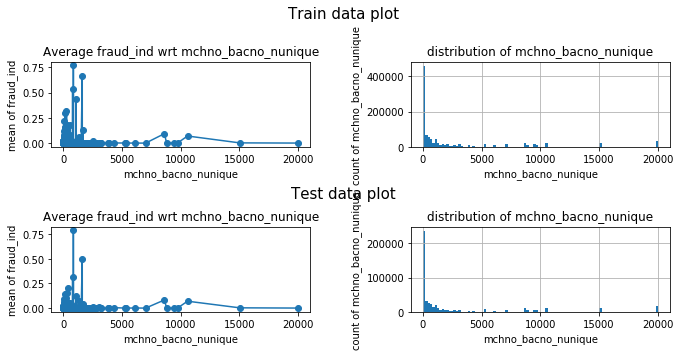

acqic_bacno_nunique


<Figure size 432x288 with 0 Axes>

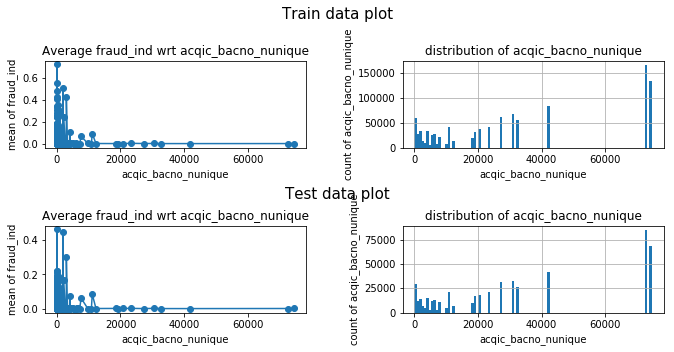

mcc_bacno_nunique


<Figure size 432x288 with 0 Axes>

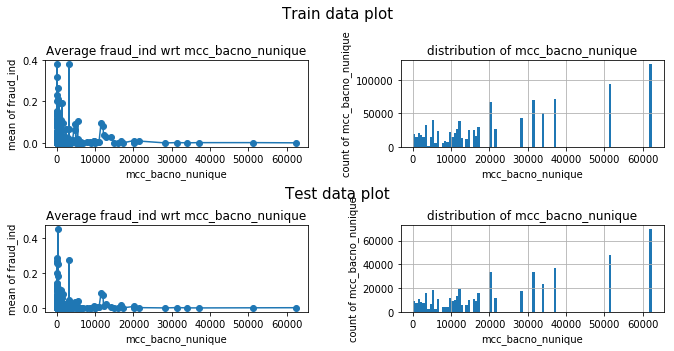

stocn_bacno_nunique


<Figure size 432x288 with 0 Axes>

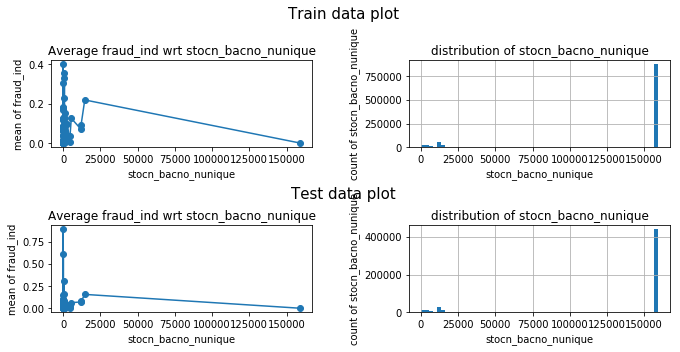

scity_bacno_nunique


<Figure size 432x288 with 0 Axes>

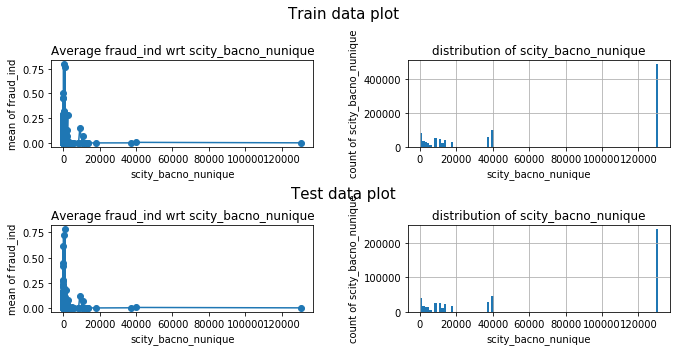

csmcu_bacno_nunique


<Figure size 432x288 with 0 Axes>

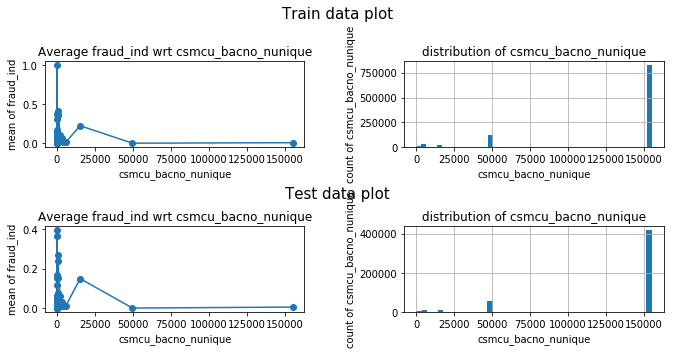

mchno_cano_nunique


<Figure size 432x288 with 0 Axes>

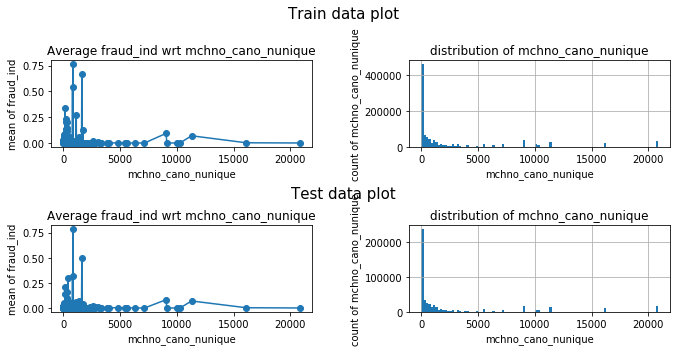

acqic_cano_nunique


<Figure size 432x288 with 0 Axes>

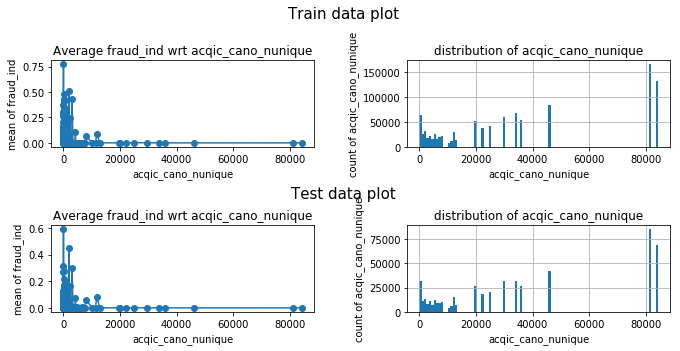

mcc_cano_nunique


<Figure size 432x288 with 0 Axes>

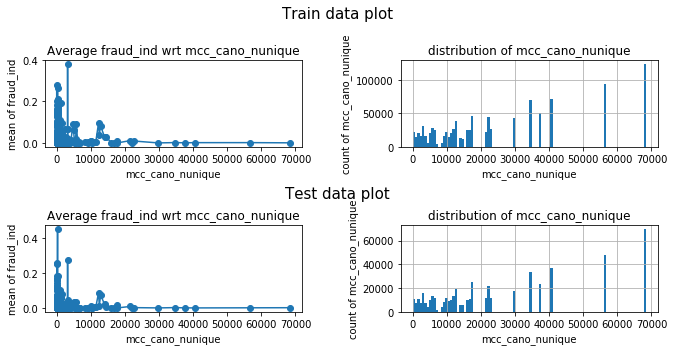

stocn_cano_nunique


<Figure size 432x288 with 0 Axes>

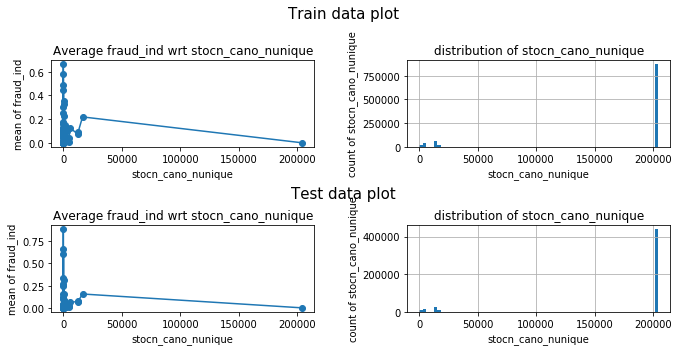

scity_cano_nunique


<Figure size 432x288 with 0 Axes>

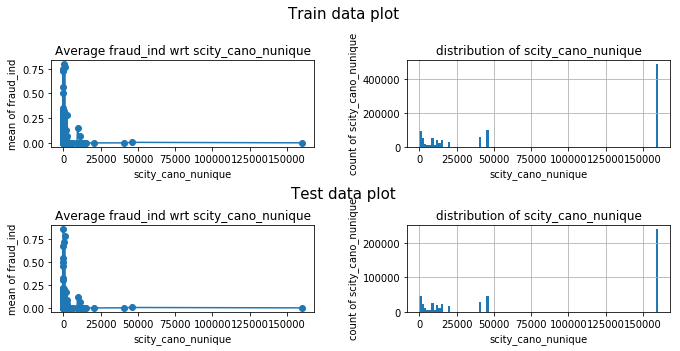

csmcu_cano_nunique


<Figure size 432x288 with 0 Axes>

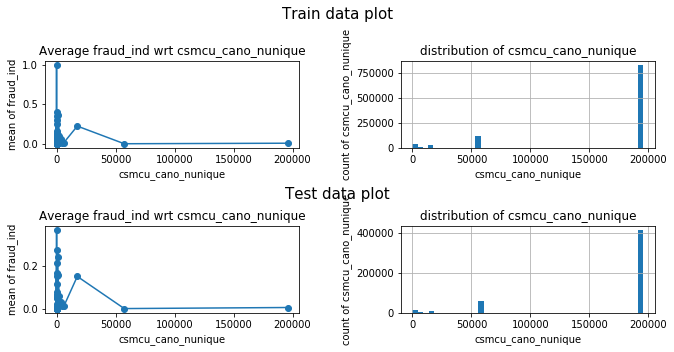

mchno_value_counts_all


<Figure size 432x288 with 0 Axes>

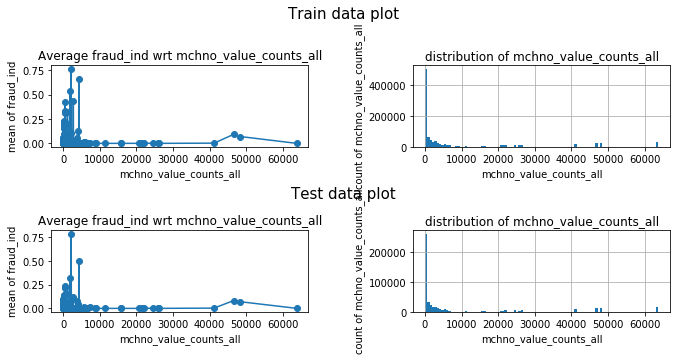

acqic_value_counts_all


<Figure size 432x288 with 0 Axes>

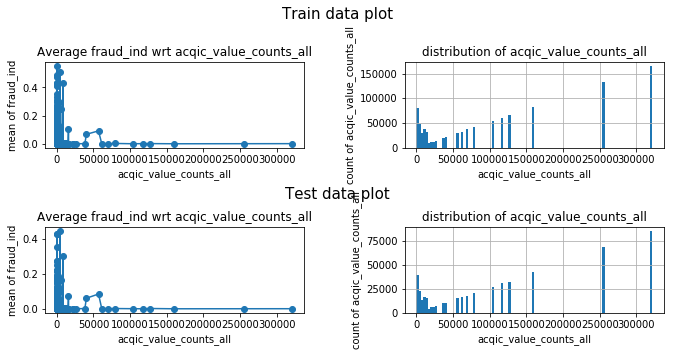

mcc_value_counts_all


<Figure size 432x288 with 0 Axes>

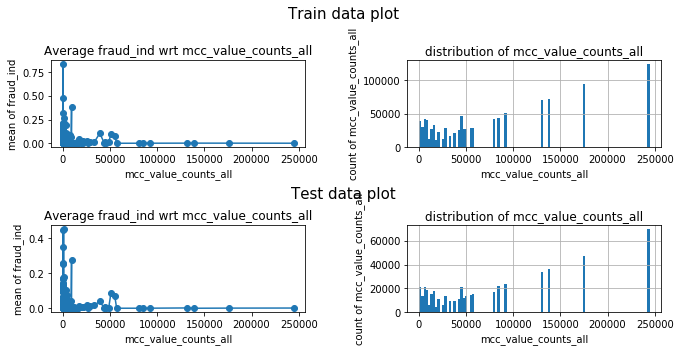

stocn_value_counts_all


<Figure size 432x288 with 0 Axes>

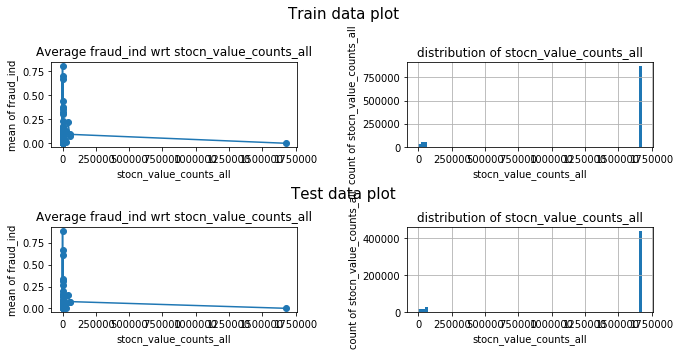

scity_value_counts_all


<Figure size 432x288 with 0 Axes>

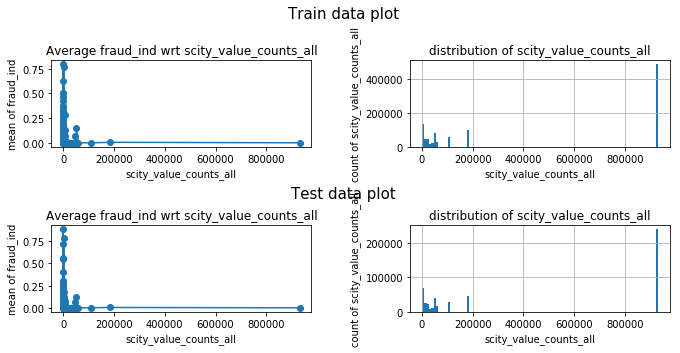

csmcu_value_counts_all


<Figure size 432x288 with 0 Axes>

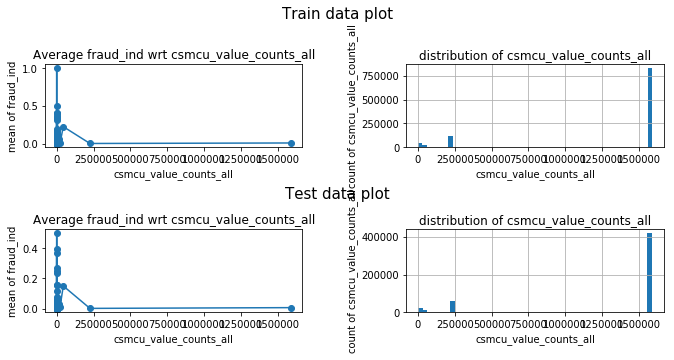

bacno_stocn_nunique


<Figure size 432x288 with 0 Axes>

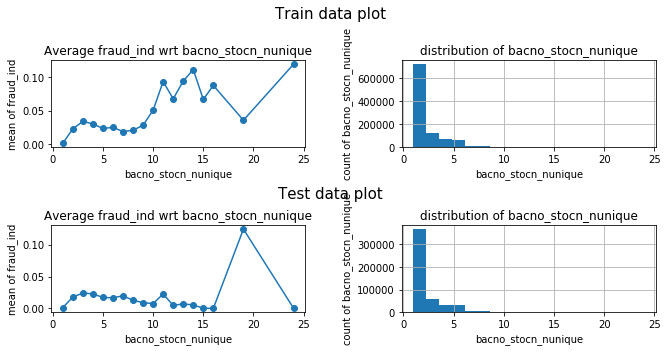

stocn_value_counts


<Figure size 432x288 with 0 Axes>

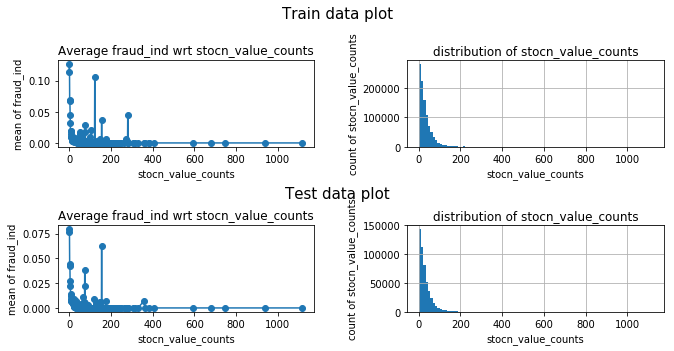

stocn_ratio


<Figure size 432x288 with 0 Axes>

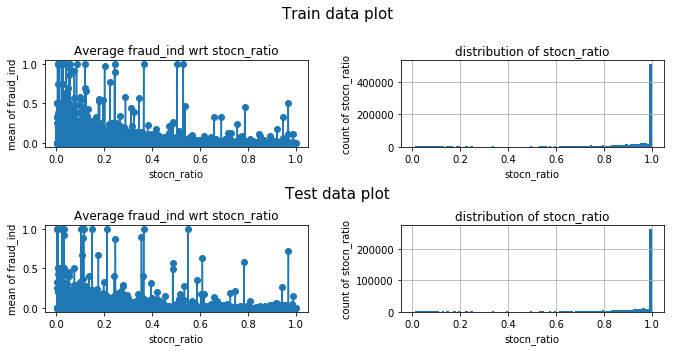

bacno_csmcu_nunique


<Figure size 432x288 with 0 Axes>

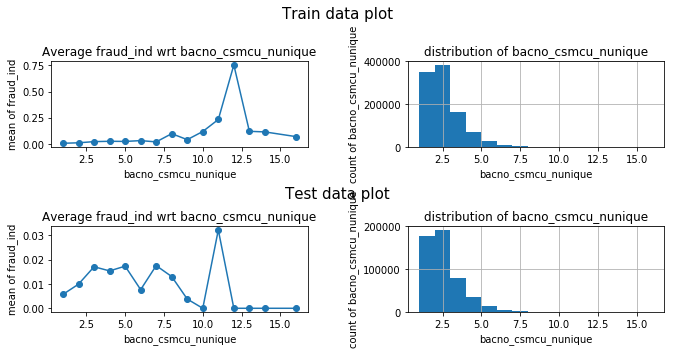

csmcu_value_counts


<Figure size 432x288 with 0 Axes>

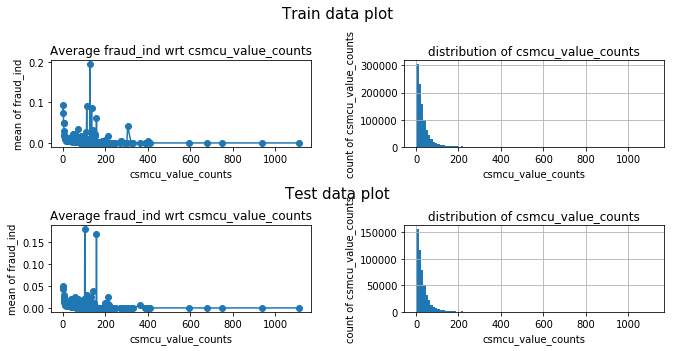

csmcu_ratio


<Figure size 432x288 with 0 Axes>

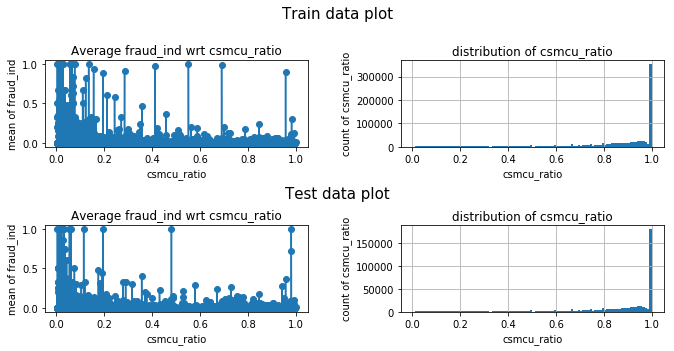

bacno_mchno_nunique


<Figure size 432x288 with 0 Axes>

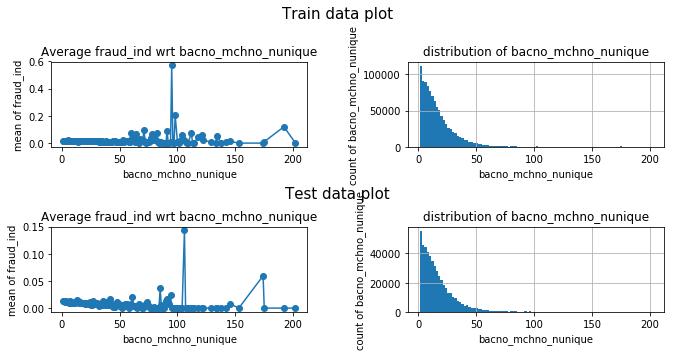

mchno_value_counts


<Figure size 432x288 with 0 Axes>

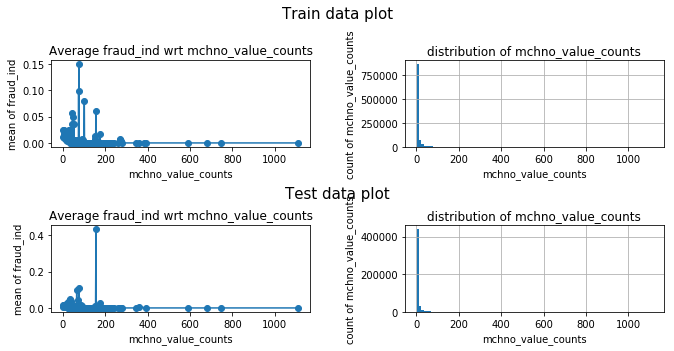

mchno_ratio


<Figure size 432x288 with 0 Axes>

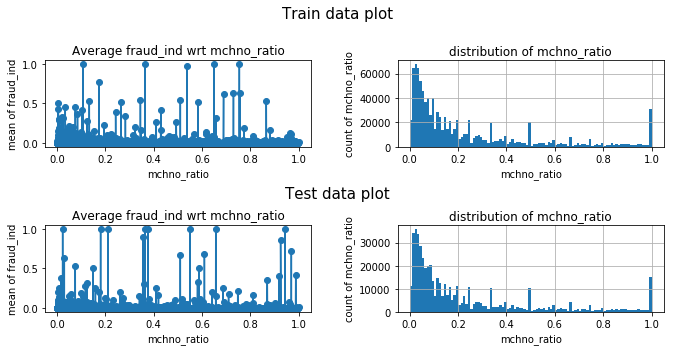

bacno_acqic_nunique


<Figure size 432x288 with 0 Axes>

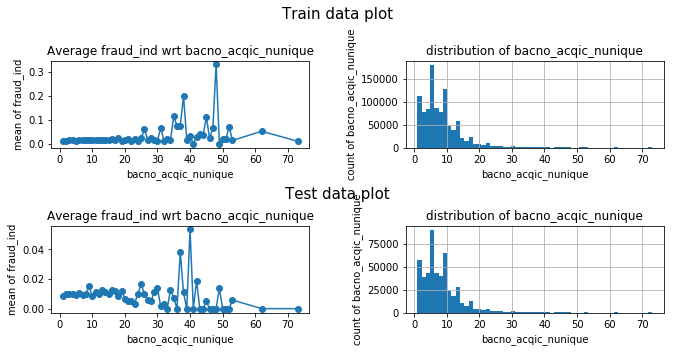

acqic_value_counts


<Figure size 432x288 with 0 Axes>

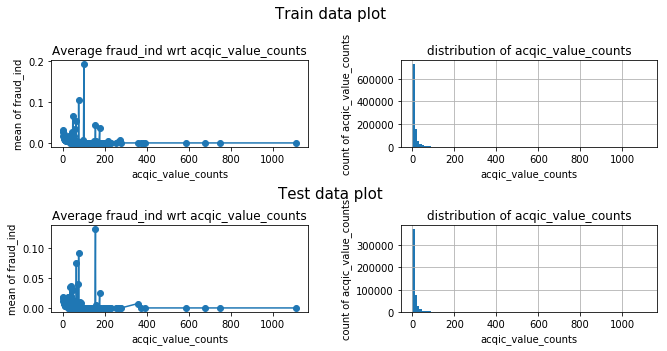

acqic_ratio


<Figure size 432x288 with 0 Axes>

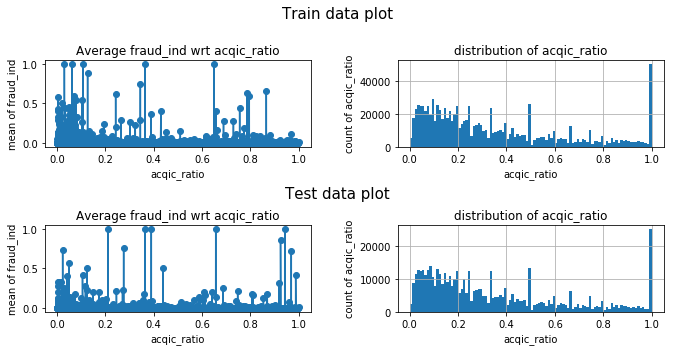

bacno_mcc_nunique


<Figure size 432x288 with 0 Axes>

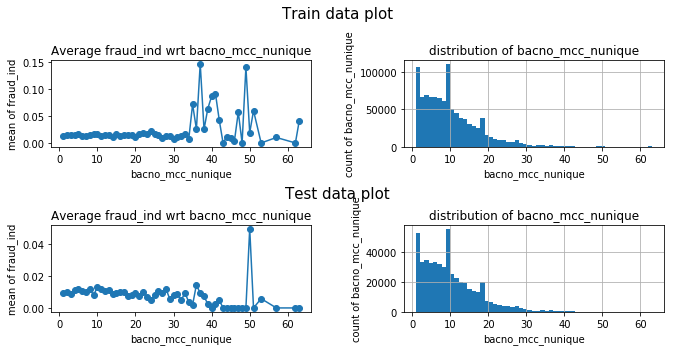

mcc_value_counts


<Figure size 432x288 with 0 Axes>

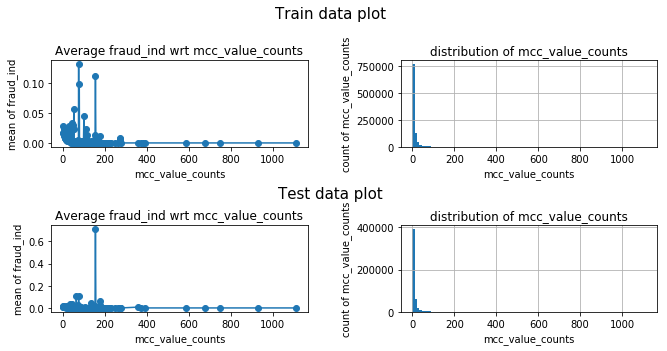

mcc_ratio


<Figure size 432x288 with 0 Axes>

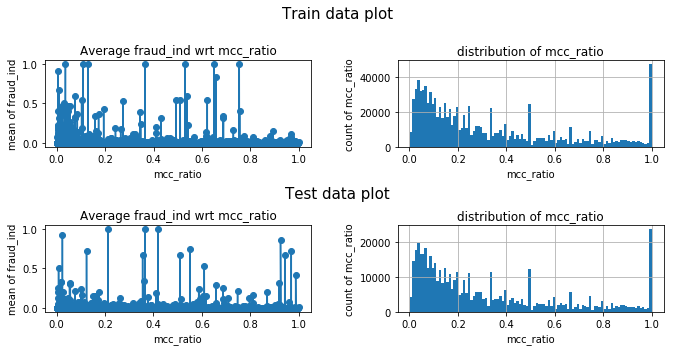

bacno_scity_nunique


<Figure size 432x288 with 0 Axes>

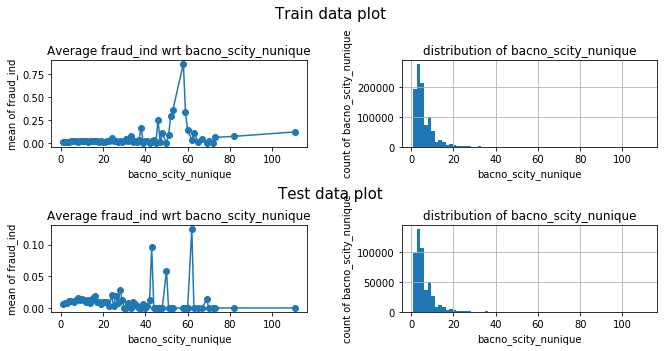

scity_value_counts


<Figure size 432x288 with 0 Axes>

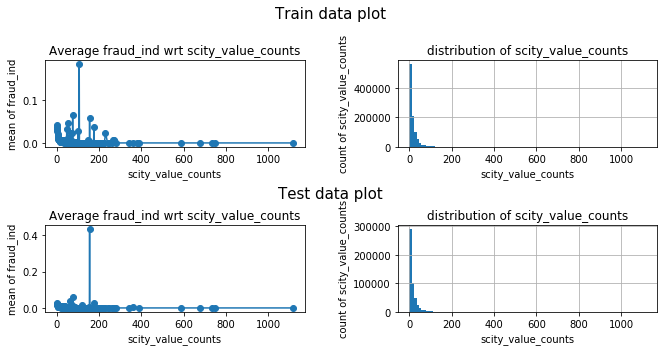

scity_ratio


<Figure size 432x288 with 0 Axes>

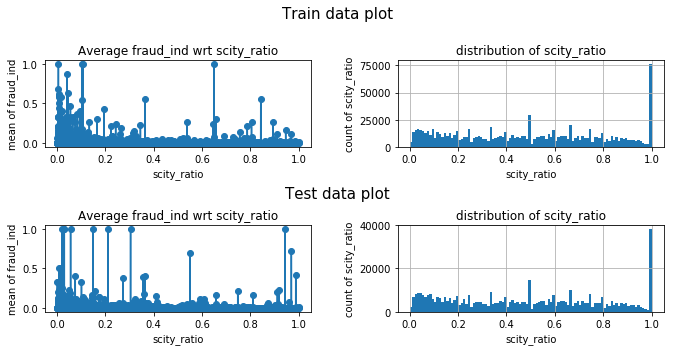

bacno_contp_nunique


<Figure size 432x288 with 0 Axes>

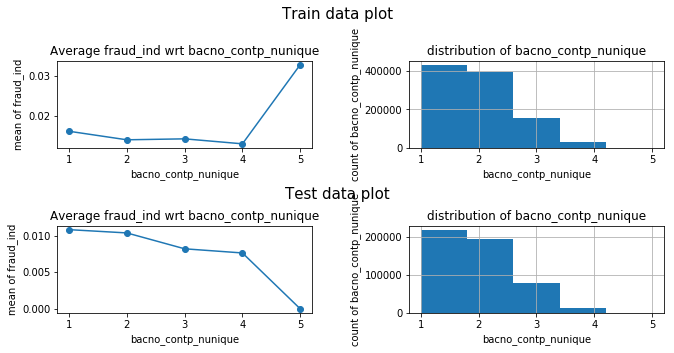

contp_value_counts


<Figure size 432x288 with 0 Axes>

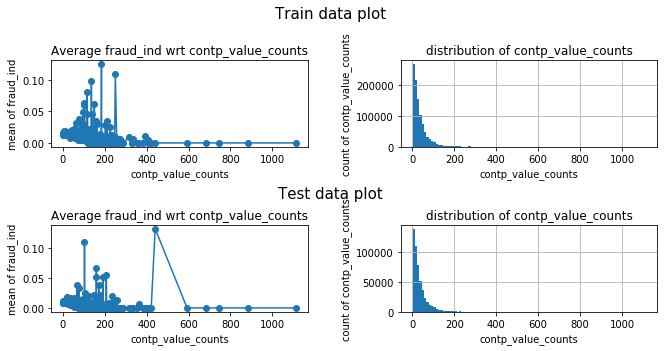

contp_ratio


<Figure size 432x288 with 0 Axes>

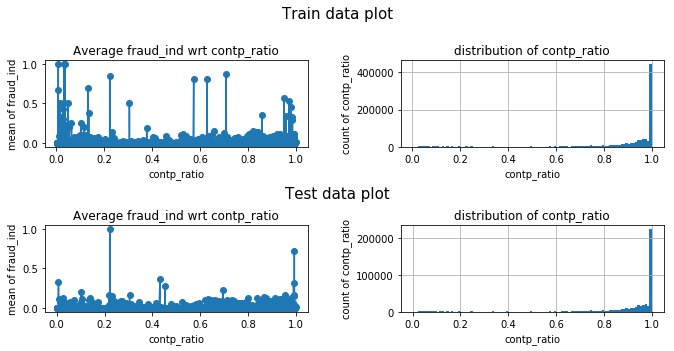

bacno_etymd_nunique


<Figure size 432x288 with 0 Axes>

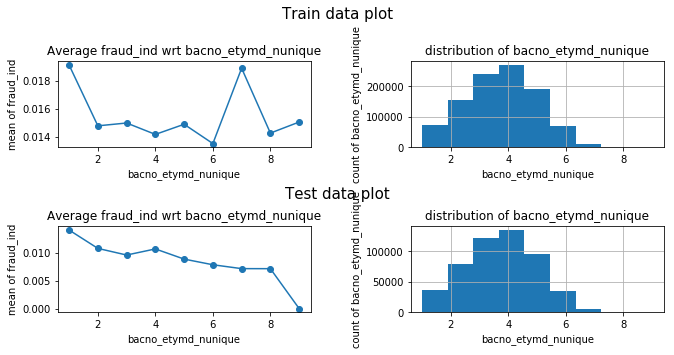

etymd_value_counts


<Figure size 432x288 with 0 Axes>

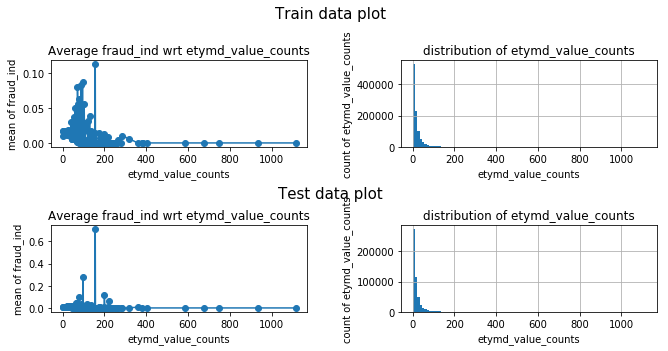

etymd_ratio


<Figure size 432x288 with 0 Axes>

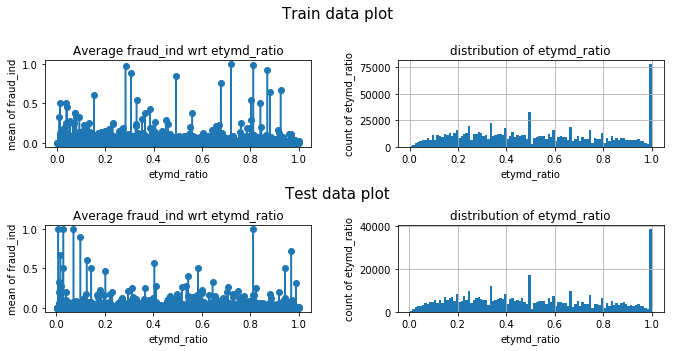

bacno_stscd_nunique


<Figure size 432x288 with 0 Axes>

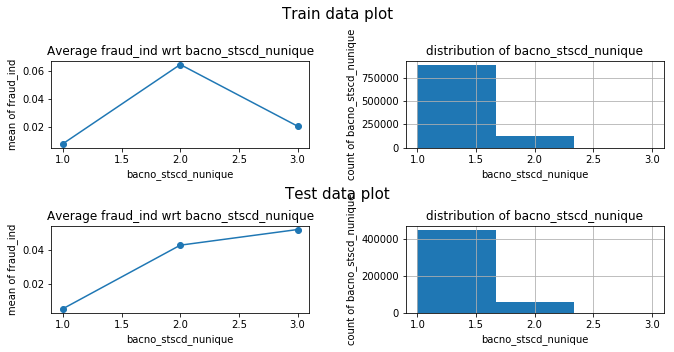

stscd_value_counts


<Figure size 432x288 with 0 Axes>

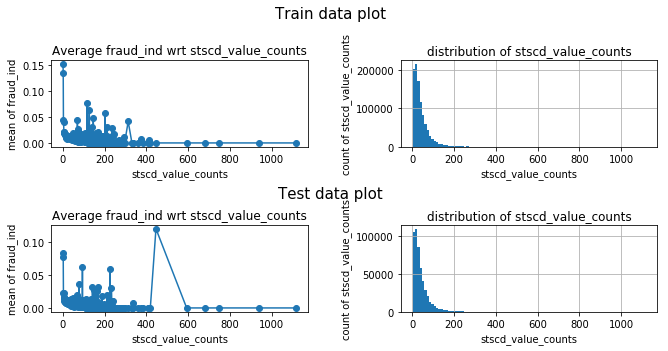

stscd_ratio


<Figure size 432x288 with 0 Axes>

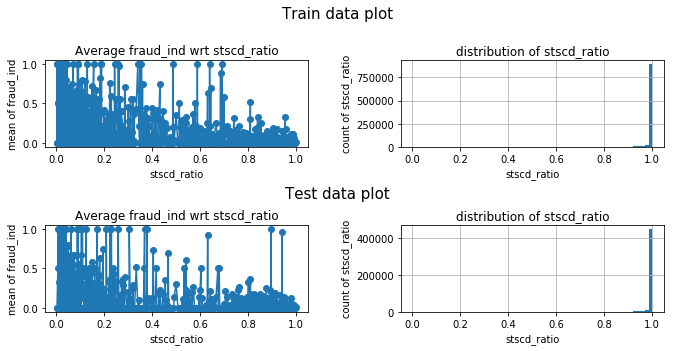

bacno_hcefg_nunique


<Figure size 432x288 with 0 Axes>

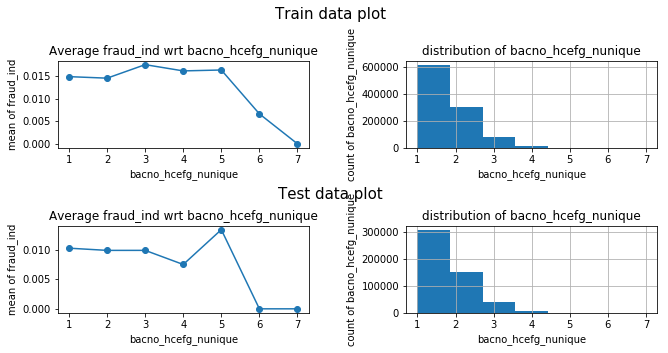

hcefg_value_counts


<Figure size 432x288 with 0 Axes>

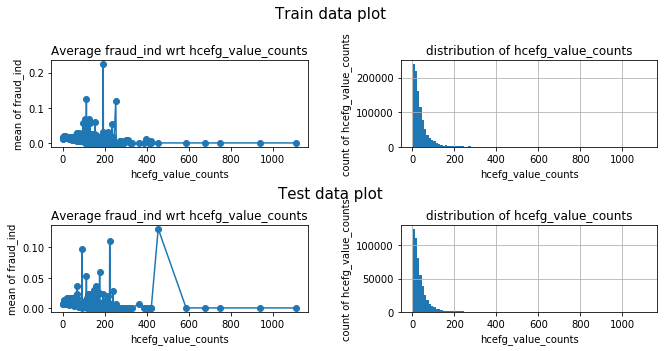

hcefg_ratio


<Figure size 432x288 with 0 Axes>

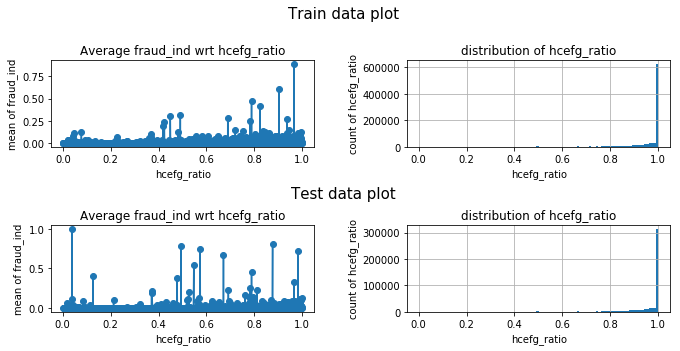

cano_only_consecutive_stscd2


<Figure size 432x288 with 0 Axes>

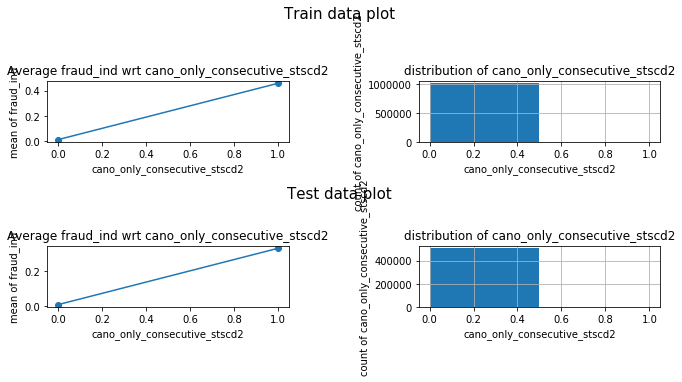

bacno_consecutive_and_only_ecfg


<Figure size 432x288 with 0 Axes>

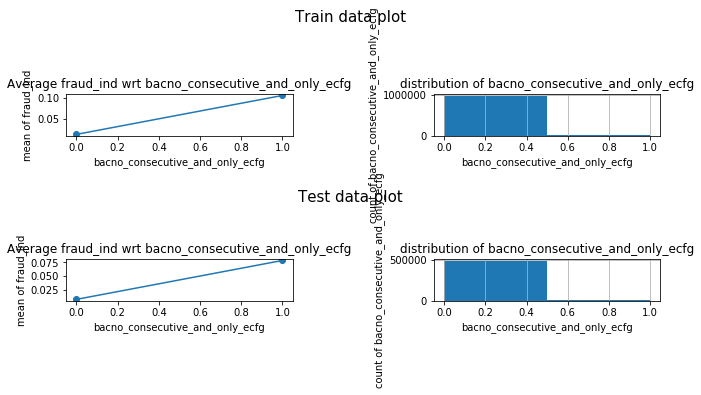

cano_lastday_use


<Figure size 432x288 with 0 Axes>

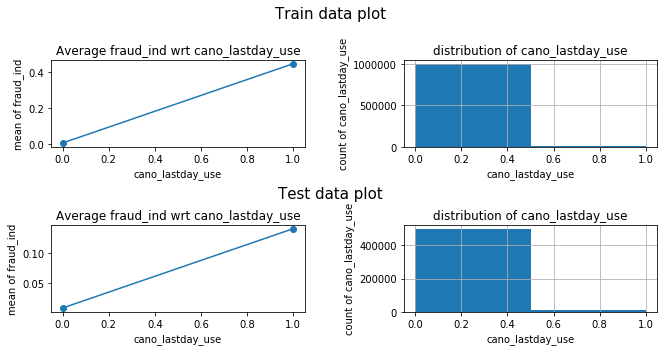

cano_lastday_use_twokind


<Figure size 432x288 with 0 Axes>

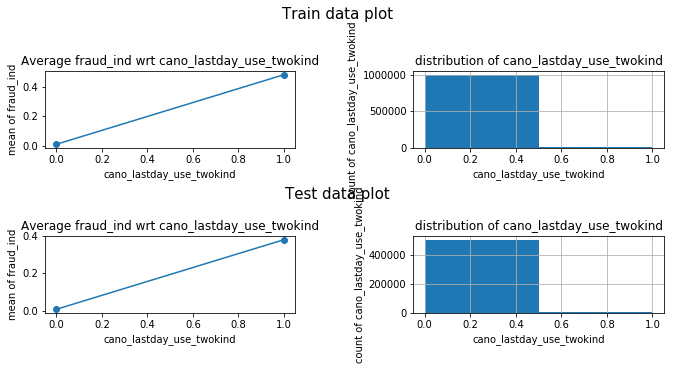

cano_lastlocdt


<Figure size 432x288 with 0 Axes>

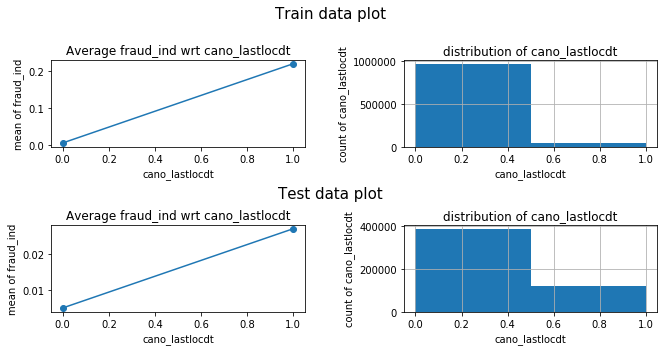

bacno_lastlocdt


<Figure size 432x288 with 0 Axes>

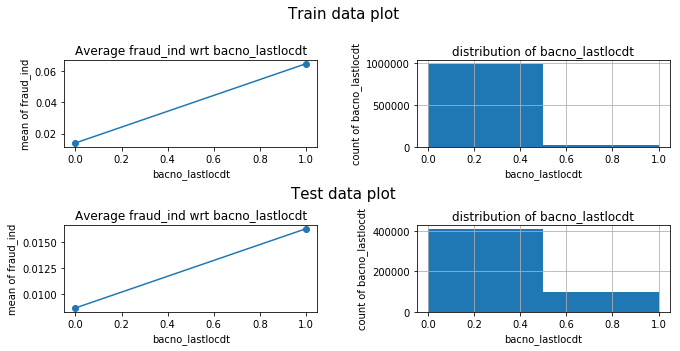

cano_lastlocdt2


<Figure size 432x288 with 0 Axes>

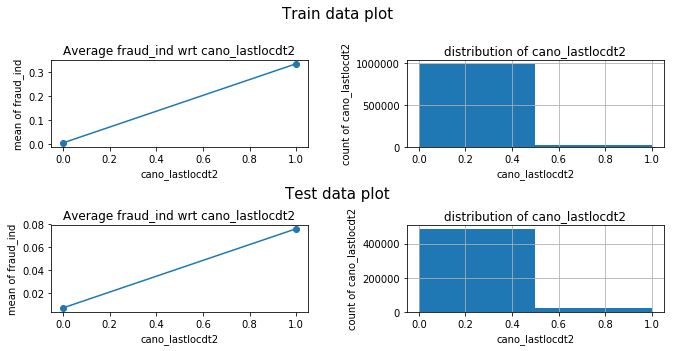

bacno_stscd_equal2


<Figure size 432x288 with 0 Axes>

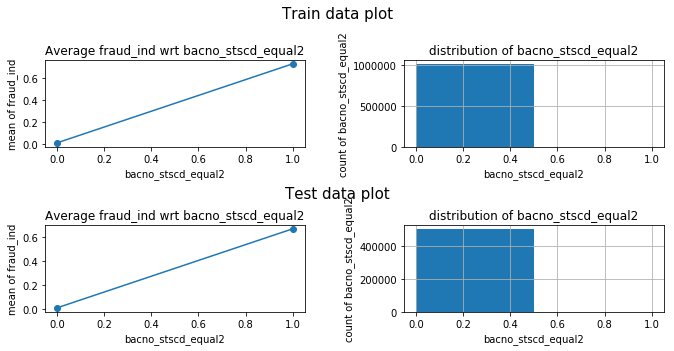

bacno_ecfg_equal1


<Figure size 432x288 with 0 Axes>

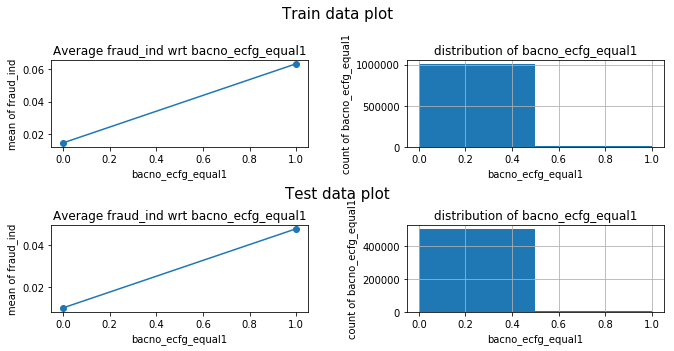

bacno_1_count


<Figure size 432x288 with 0 Axes>

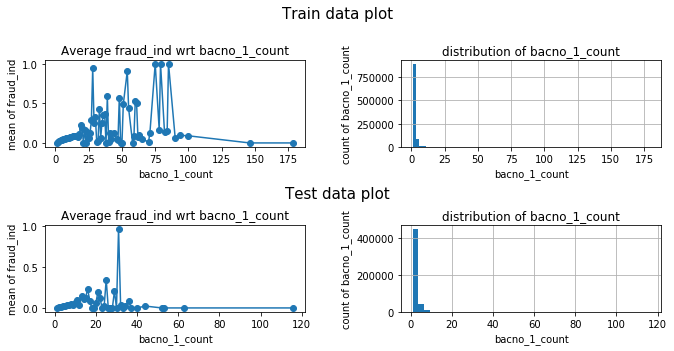

bacno_2day_count


ValueError: Grouper for 'bacno_2day_count' not 1-dimensional

<Figure size 432x288 with 0 Axes>

In [5]:
train_d = all_data[all_data['locdt']<=60]
valid_d = all_data[(all_data['locdt']>60)&(all_data['locdt']<=90)]
# 自己做的圖表function，畵資料分佈的bar chart和對fraud_ind的關係

for c in train_d.columns:
    analze_distribution(train_d,'fraud_ind',c,valid_d)


from featexp import get_univariate_plots
# get_univariate_plots(data=train_d, target_col='fraud_ind', features_list=['hcefg'], bins=100, data_test=valid_d)
# get_univariate_plots(data=train_d, target_col='fraud_ind', features_list=['loctm_hr'], bins=10, data_test=valid_d)
# get_univariate_plots(data=train_d, target_col='fraud_ind', features_list=['flg_3dsmk'], bins=10, data_test=valid_d)
# get_univariate_plots(data=train_d, target_col='fraud_ind', features_list=['csmcu'], bins=100, data_test=valid_d)

In [8]:
print(all_data.bacno_2day_count)

         bacno_2day_count  bacno_2day_count
0                       1                 0
1                       2                 0
2                       1                 0
3                       1                 0
4                       1                 0
5                       1                 0
6                       1                 0
7                       1                 0
8                       2                 0
9                       2                 0
10                      1                 0
11                      3                 0
12                      3                 0
13                      3                 0
14                      7                 0
15                      7                 0
16                      7                 0
17                      7                 0
18                      4                 0
19                      4                 0
20                      4                 0
21                      4       

## 檢查train和test data的分佈有哪裡不一樣

In [ ]:
def compare_distribution(train_data,test_data,target_name):
    target = train_data[target_name]
    target2 = test_data[target_name]
    print(target_name)
    print('nunique train',target.nunique())
    print('nunique test',target2.nunique())
    print('max train',target.max())
    print('max test',target2.max())

    fig, axs = plt.subplots(1,2,figsize=(10,3))
    
    bins = target.nunique() if target.nunique()<100 else 100
    target.hist(bins=bins,ax=axs[0])
    
    bins = target2.nunique() if target2.nunique()<100 else 100
    target2.hist(bins=bins,ax=axs[1])
    plt.show()


for c in all_data.drop(columns='fraud_ind'):
    compare_distribution(all_data[all_data['locdt']<=90].drop(columns='fraud_ind'),all_data[all_data['locdt']>90].drop(columns='fraud_ind'),c)

## fraud資料和normal資料的各個特徵差異

In [ ]:
normal_data = all_data[all_data['fraud_ind']==0]
fraud_data = all_data[all_data['fraud_ind']==1]

for c in normal_data.columns:
    print(c)
    plt.clf()
    fig, axs = plt.subplots(1,2,figsize=(10,3))

    bins = normal_data[c].nunique() if normal_data[c].nunique()<100 else 100
    normal_data[c].hist(bins=bins,ax=axs[0])
    axs[0].set_title('Normal data')
    bins = fraud_data[c].nunique() if fraud_data[c].nunique()<100 else 100
    fraud_data[c].hist(bins=bins,ax=axs[1])
    axs[1].set_title('Fraud data')
    plt.show()


### 檢查在test data中,新出現的類別有多少
bacno, mchno, acqic, mcc, stocn, scity, csmcu 

In [ ]:
def find_new_category(x,target_name):
    x_train = x[x['locdt']<=90][target_name].unique()
    x_test = x[x['locdt']>90][target_name].unique()
    
    print(target_name)
    print('{} categories in Training data:'.format(x_train.shape[0]))
    print('{} categories in Testing data:'.format(x_test.shape[0]))

    x_new_test=[]
    for b in x_test:
        if b not in x_train:
            x_new_test.append(b)

    print('{} new categories'.format(len(x_new_test)))    

In [ ]:
## 幾乎所有在test data的都是新用戶 乾
## 所以重點特徵工程不能使用用戶過去的fraud記錄
# find_new_category(all_data,'bacno')

## 幾乎都太多只出現在test data上的新類別,這樣得轉換可以用來訓練(TODO)

# find_new_category(all_data,'mchno')
# find_new_category(all_data,'acqic')
# find_new_category(all_data,'mcc')
# find_new_category(all_data,'stocn')
# find_new_category(all_data,'scity')
# find_new_category(all_data,'csmcu')


## 觀察large category的feature是否有很多種bacno的fraud

In [ ]:
# mchno_bacno_count = all_data.groupby('mchno').apply(lambda s:s[s['fraud_ind']==1]['bacno'].nunique())
# acqic_bacno_count = all_data.groupby('acqic').apply(lambda s:s[s['fraud_ind']==1]['bacno'].nunique())
# mcc_bacno_count = all_data.groupby('mcc').apply(lambda s:s[s['fraud_ind']==1]['bacno'].nunique())

# print(mchno_bacno_count.sum())
# print(mchno_bacno_count[mchno_bacno_count>1].sort_values())

# print(acqic_bacno_count.sum())
# print(acqic_bacno_count[acqic_bacno_count>1].sort_values())

# print(mcc_bacno_count.sum())
# print(mcc_bacno_count[mcc_bacno_count>1].sort_values())

## 以每個bacno來看fraud情況
* 找出使用者被盜刷卡時，和一般的交易差在哪裡


In [10]:
bacno_fraud_count = all_data.groupby('bacno').apply(lambda s:s[s['fraud_ind']==1]['bacno'].shape[0])

In [11]:
# print('All fraud instance',all_data.fraud_ind.sum(skipna=True))
# print('{} different bacno'.format(bacno_fraud_count[bacno_fraud_count>0].shape[0]))

# bacno_fraud_count[(bacno_fraud_count<10)&(bacno_fraud_count>0)].hist(bins=9)
# plt.show()
# plt.clf()
# bacno_fraud_count[(bacno_fraud_count>0)].hist(bins=100)

## 幾乎都只被騙過一兩次

In [12]:
list1=['locdt','cano','etymd','mchno','acqic','mcc','stocn','conam','fraud_ind']
list2=['locdt','conam','cano','ecfg','stscd','stocn','mchno','fraud_ind']
list3=['locdt','conam','cano','stocn','scity','flbmk','csmcu','ecfg','fraud_ind']
list4=['locdt','cano','mcc','etymd','stocn','scity','csmcu','fraud_ind']
# 
# ,'ecfg','etymd'
bacno_10fraud_more_list = bacno_fraud_count[(bacno_fraud_count==1)].index
pd.set_option('display.max_rows', 1000)
# print(x)
# pd.reset_option('display.max_rows')

cnt=0
for b in bacno_10fraud_more_list:
    cnt+=1
    if cnt>300:
        break
    print()
    
    print(b,all_data[all_data['bacno']==b]['fraud_ind'].sum())
    if all_data[all_data['bacno']==b]['ecfg'].sum()>=0:
        print(all_data[all_data['bacno']==b][list2].sort_values(by=['locdt']))
        
#     print(all_data[all_data['bacno']==b][list4].sort_values(by=['locdt']))


2 1.0
     locdt    conam    cano  ecfg  stscd  stocn   mchno  fraud_ind
11       1   541.07   96923     0      0    102   77960        0.0
12       1   151.14   96923     0      0    102   30194        0.0
13       1   683.25   96923     0      0    102   87352        0.0
14       2   177.04   96923     0      0    102   30194        0.0
15       2   435.32   96923     0      0    102   77960        0.0
16       2   365.63   96923     0      0    102   77960        0.0
17       2   969.14   96923     0      0    102   87352        0.0
21       5   743.53  101555     0      0    102   93829        0.0
20       5  2291.16  101555     1      0    102   53657        0.0
18       5   499.21   96923     0      0    102   77960        0.0
19       5   288.05   96923     0      0    102   30194        0.0
22       6   229.88   96923     0      0    102   89739        0.0
23       7   170.00   96923     0      0    102   77960        0.0
24       7   229.88   96923     0      0    102   30194

      locdt    conam   cano  ecfg  stscd  stocn  mchno  fraud_ind
1497      1  1067.26  65013     0      0     46  54174        0.0
1498      3   383.76  65013     0      0    102  46303        0.0
1499      5   543.11  65013     0      0    102  46303        0.0
1500      6   732.76  65013     0      0    102  51459        0.0
1501      6   443.90  65013     0      0    102  88709        0.0
1502     10  1191.89  65013     0      0     52  58830        0.0
1503     11   627.91  65013     0      0     52  68608        0.0
1504     11   692.10  65013     0      0     52  67139        0.0
1505     11   419.15  65013     0      0     52  65663        0.0
1506     11   601.18  65013     0      0    102  46303        0.0
1508     13   531.12  65013     1      0     46  54828        0.0
1507     13   516.46  65013     0      0    102  92683        0.0
1509     14   626.30  65013     0      0    102  92683        0.0
1510     14   776.78  65013     1      0    102  20434        0.0
1511     1

585 1.0
      locdt    conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
5970      2   513.80  178169     0      0    102  73865        0.0
5971      5   894.10  178169     0      0    102  79320        0.0
5972      8   798.07  178169     0      0    102  78071        0.0
5973     14   818.43  178169     0      0    102  77995        0.0
5974     18   896.24  178169     0      0    102  79320        0.0
5975     20  1121.92  178169     0      0    102  78071        0.0
5976     20   698.40  178169     0      0    102  77995        0.0
5977     23   567.30  178169     0      0    102  93670        0.0
5978     25   715.62  178169     0      0    102  79320        0.0
5979     27   801.57  178169     0      0    102  77995        0.0
5980     28   759.66  178169     0      0    102  77671        0.0
5981     37   629.74  178169     0      0    102  13550        0.0
5982     38   921.80  178169     0      0    102  81372        0.0
5983     43  1209.08  178169     0      0    102  7803

1007 1.0
       locdt   conam   cano  ecfg  stscd  stocn  mchno  fraud_ind
10270     20  556.99  70140     1      0    102  34309        0.0
10271     49  560.46  70140     1      0    102  34309        0.0
10272     71    0.00  70140     1      2    104  43464        1.0
10273     84  562.37  70141     1      0    102  34309        0.0

1017 1.0
       locdt    conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
10417     19  1070.72  129094     1      0     44  33794        0.0
10418     20   713.91  129094     1      0    102  20435        0.0
10419     28  1966.79  129094     1      0    102  34179        0.0
10420     30   932.13  129094     1      2     27  66694        1.0
10421     61   713.91  129095     1      0    102  20437        0.0
10422     78  1237.60  129095     1      0    102  77859        0.0

1025 1.0
       locdt    conam   cano  ecfg  stscd  stocn  mchno  fraud_ind
10524      3   465.62  30089     0      0    102      0        0.0
10525      3  1304.96  30089   

       locdt   conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
15260      7  691.95  154397     1      0    102  38244        0.0
15261     18  454.96  154397     1      0    102  20129        0.0
15262     37  636.82  154397     1      0    102  20129        0.0
15263     39    0.00  154397     1      0     38  54238        0.0
15264     39  937.88  154397     1      0    104  55807        0.0
15265     39  937.88  154397     1      0    104  55807        1.0

1524 1.0
       locdt    conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
15598      1   580.44  191035     0      0     46  55027        0.0
15599      9  1188.45  191035     1      0     20  44859        0.0
15600     12   883.44  191035     1      0     36  44144        0.0
15601     12  1605.05  191035     1      0     75  67585        0.0
15602     15   652.03  191035     0      0    102  74961        0.0
15603     27  1350.77  191035     0      0    102  78070        0.0
15604     31   632.92  191035     0      0   

2164 1.0
       locdt   conam   cano  ecfg  stscd  stocn  mchno  fraud_ind
21327      1  513.80  91750     0      0    102  97709        0.0
21328      1  790.97  91750     0      0    102  97293        0.0
21329      6  612.50  91750     0      0    102  96597        0.0
21330     10  513.80  91750     0      0    102  97335        0.0
21331     13  555.04  91750     1      0    102  82174        0.0
21332     13  555.04  91750     1      0    102  82174        0.0
21333     18  513.80  91750     0      0    102  97335        0.0
21334     24  513.80  91750     0      0    102  97335        0.0
21335     25  465.62  91750     0      0    102      0        0.0
21336     31  653.77  91750     0      0    102  97335        0.0
21338     36  614.46  91750     1      0    102  34217        0.0
21337     36  244.05  91750     1      0    102  34217        0.0
21339     42  513.80  91750     0      0    102  97709        0.0
21340     45  724.05  91750     0      0    102  61221        0.0
2

       locdt    conam   cano  ecfg  stscd  stocn  mchno  fraud_ind
24010     17  1574.45  32690     1      2     52  57089        1.0
24011     19   598.80  32690     1      0    102  34217        0.0

2509 1.0
       locdt    conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
24587      5   513.80  106249     0      0    102  59333        0.0
24588      8   513.80  106249     0      0    102  59333        0.0
24589     10   513.80  106249     0      0    102  59369        0.0
24590     11  1130.35  106249     0      0    102  27946        0.0
24591     13   513.80  106249     0      0    102  59333        0.0
24592     16   513.80  106249     0      0    102  59369        0.0
24593     18   513.80  106249     0      0    102  59369        0.0
24594     19   791.17  106249     1      0    102  34217        0.0
24595     21   513.80  106249     0      0    102  59369        0.0
24596     22  1297.50  106249     0      0    102  14473        0.0
24597     27   513.80  106249     0      

2825 1.0
       locdt    conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
27342      2   513.80  182670     0      0    102  59333        0.0
27343     14   513.80  182670     0      0    102  59333        0.0
27344     15   627.87  182670     0      0    102  73575        0.0
27345     17   546.73  182670     0      0    102  77035        0.0
27346     20   513.80  182670     0      0    102  59333        0.0
27347     34  2170.05  182670     0      0    102  53952        0.0
27348     34   513.80  182670     0      0    102  59333        0.0
27349     48  1685.54  182670     1      2    104    568        1.0
27350     50   602.53  182670     0      0    102  88701        0.0
27351     52   404.65  182670     0      0    102  77035        0.0
27352     61   513.80  182671     0      0    102  68930        0.0
27353     64   513.80  182671     0      0    102  59333        0.0
27354     68   513.80  182671     0      0    102  75492        0.0
27355     72   881.18  182671     0    

3218 1.0
       locdt    conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
31062      1   939.47  109065     0      0    102  50436        0.0
31063      1  1520.93   30235     0      0    102  12814        0.0
31064      4   426.47   30234     0      0     75  66661        0.0
31065      5  1898.37  109065     0      0    102  50436        0.0
31066      5  1498.18  109065     0      0    102  50436        0.0
31067      9   420.41  109064     0      0    104  10925        0.0
31068     10  1110.00   30235     0      0    102  94582        0.0
31069     20   919.21  109064     0      0    102  17818        0.0
31070     21     0.00   30234     0      0    102   2461        0.0
31071     21     0.00  109064     0      0    102   2461        0.0
31072     21     0.00   30234     0      0    102   2467        0.0
31073     21     0.00  109064     0      0    102   2467        0.0
31074     24   737.61  109064     0      0    102  14166        0.0
31075     25   317.01  109064     0    

4060 1.0
       locdt    conam    cano  ecfg  stscd  stocn   mchno  fraud_ind
38251      1  1012.88  119913     1      0    102   84730        0.0
38252      2  1022.03  119913     1      0    102   34309        0.0
38253      4     0.00  119913     1      0     38   55537        0.0
38254      4   755.96  119913     1      0     38   55537        0.0
38255      5   648.22  119913     1      0    102   34176        0.0
38256      6   685.91  119913     1      0    102    1605        0.0
38257      7   480.90  119913     1      0    102   84903        0.0
38258      9   976.50  119913     1      0    102    1605        0.0
38259     11   475.90  119913     1      0    102   84903        0.0
38262     15   752.89  119913     0      0    102   74729        0.0
38263     15   475.90  119913     1      0    102   84903        0.0
38260     15     0.00  119913     1      0     20   44859        0.0
38261     15   672.36  119913     1      0     20   41885        0.0
38264     17   464.78  11

4839 1.0
       locdt    conam    cano  ecfg  stscd  stocn   mchno  fraud_ind
44949      1   736.00  110202     0      0    102   92452        0.0
44950      3  1273.09  110202     0      0    102   30913        0.0
44951      3   458.74  110202     0      0    102   30913        0.0
44952     17   881.81  110202     0      0    102   77136        0.0
44953     37   884.64    3857     0      0    102   44793        0.0
44954     37  1022.26    3857     0      0    102   46222        0.0
44955     48   878.48    3857     0      0    102   39462        0.0
44956     48   868.48    3857     0      0    102   39462        0.0
44959     55   591.90    3857     0      0    102   46341        0.0
44960     55   980.63    3857     0      0    102   46341        0.0
44957     55   451.69    3857     0      0    102   46339        0.0
44958     55   774.70    3857     0      0    102   46341        0.0
44961     57  1897.46  110202     0      0    102  102401        0.0
44962     60   801.77  11

5657 1.0
       locdt    conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
51956      2   983.61  156429     0      0    102  19499        0.0
51957      9     0.00  156429     0      0     44  33794        0.0
51958     10   682.99  156429     1      0    102  34176        0.0
51959     12   547.53  156429     0      0    102  24310        0.0
51960     16  1593.74  156429     1      0     38  75079        1.0
51961     22   672.97  156430     0      0    102  98902        0.0
51962     23   755.52  156430     0      0    102  75732        0.0
51963     24   260.85  156430     0      0    102  62665        0.0
51965     25  1701.26  156430     0      0    102  38734        0.0
51964     25   661.81  156430     0      0    102  98902        0.0
51966     29   625.35  156430     0      0    102  92185        0.0
51967     31  1252.11  156430     0      0    102  69816        0.0
51968     31   638.04  156430     0      0    102  91103        0.0
51969     71   240.27  156430     0    

5907 1.0
         locdt   conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
54510       28  956.15  209699     0      0    102  96813        0.0
54511       71  615.76  209699     1      0     46  54174        1.0
1536325     91  426.47  209699     0      0     46  54174        NaN

5939 1.0
       locdt    conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
54876     31   943.29  149770     0      0    102  60277        0.0
54877     44     0.00  149770     1      0     38  54238        0.0
54878     44   794.93  149770     1      0     38  54238        0.0
54879     44   794.93  149770     1      0     38  54238        1.0
54880     73  1199.29  149771     0      0    102  78098        0.0

6021 1.0
       locdt   conam   cano  ecfg  stscd  stocn  mchno  fraud_ind
55616      2  168.20  39337     1      0     38  54238        1.0
55617     54  166.38  39338     0      0    102  78202        0.0
55618     74  446.71  39338     0      0    102  32791        0.0

6042 1.0
       locdt 

6322 1.0
       locdt    conam   cano  ecfg  stscd  stocn  mchno  fraud_ind
58628      1   872.54  97278     1      0    102  26280        0.0
58629      1   521.72  97278     1      0    102  60217        0.0
58630      2   963.99  97278     0      0    102  88966        0.0
58631     10   735.30  97278     1      0    102  82174        0.0
58632     21   867.99  97278     1      0    102  78537        0.0
58633     24   511.57  97278     1      0    102  78537        0.0
58634     33   216.12  97278     1      0     38  54238        0.0
58635     33  2401.93  97278     0      0    102  53687        0.0
58636     35     4.77  97278     1      0    102  20125        0.0
58637     37   948.83  97278     0      0    102  78149        0.0
58638     38   201.39  97278     1      0    102  20126        0.0
58639     39   830.12  97278     1      0    102  82174        0.0
58640     48   763.74  97278     1      0    102  78537        0.0
58641     48   214.70  97278     1      0    102  201


6684 1.0
       locdt    conam  cano  ecfg  stscd  stocn  mchno  fraud_ind
61830      5   595.71  5504     1      0    102  38206        0.0
61831      6   513.80  5504     0      0    102  59369        0.0
61832     16   732.99  5504     0      0    102  34746        0.0
61833     22   884.33  5503     0      0    102  51387        0.0
61834     34   630.05  5504     1      0    102  38206        0.0
61835     35   884.33  5504     1      0    102  28653        0.0
61836     51   503.84  5504     0      0    102   2221        0.0
61837     51     0.00  5503     1      0     38  54238        1.0
61838     52   375.21  5504     0      0    102   6475        0.0
61839     55   227.20  5504     0      0    102  34399        0.0
61840     58   534.06  5504     0      0    102  23157        0.0
61841     69   389.99  5504     1      0    102  34176        0.0
61842     71   593.98  5504     1      0    102  38206        0.0
61843     71  1240.00  5504     1      0     32  57459        0.0


       locdt    conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
66924      1   325.06  136452     0      0    102   5988        0.0
66925      2   509.32  136452     0      0    102  85159        0.0
66926      3   513.80  136452     0      0    102  86584        0.0
66927      5   576.92  136452     0      0    102  41057        0.0
66928      5   513.80  136453     0      0    102  74807        0.0
66929      6   342.08  136453     0      0    102  84117        0.0
66930     10   513.80  136453     0      0    102  86584        0.0
66932     11     0.00  133277     0      0     38  54238        0.0
66933     11  1016.34  133277     1      0     38  54238        1.0
66931     11   640.76  136452     0      0    102  17794        0.0
66934     12   592.59  136453     0      0    102  16316        0.0
66935     15   652.03  133276     0      0    102  86680        0.0
66936     15   781.91  133276     1      0    102  38222        0.0
66937     15     1.38  133276     1      0    10

       locdt    conam    cano  ecfg  stscd  stocn   mchno  fraud_ind
72386      1     0.00  114424     0      0    102   59690        0.0
72387      1     0.00  114424     0      0    104  103106        0.0
72388      1     0.00  114424     0      0     46   54828        0.0
72389      3   288.05  114424     1      0     46   54828        0.0
72390      6   535.72  114424     1      0    102   34309        0.0
72391     10  1069.20  114424     1      0    102   20394        0.0
72392     10     0.00  114424     0      0     46   54828        0.0
72393     11   849.59  114424     1      0    102   20192        0.0
72394     13   965.29  114425     0      0    102   60257        0.0
72395     15   784.95  114424     1      0     46   54828        0.0
72396     15   103.48  114424     1      0     46   54828        0.0
72397     15     0.00  114424     0      0     46   54828        0.0
72398     15     0.00  114424     0      0     46   54828        0.0
72399     16   513.80  114425     

       locdt    conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
78572      7   465.62  165750     0      0    102      0        0.0
78573     15     0.00  165750     0      0     38  54238        0.0
78574     22     0.00  165750     0      0    102      0        0.0
78575     22   513.80  165750     0      0    102  59360        0.0
78576     23     1.38  165750     1      0    102  90126        0.0
78577     23   103.48  165750     1      0    102  79245        0.0
78578     25   465.62  165750     0      0    102      0        0.0
78579     25   465.62  165750     0      0    102      0        0.0
78580     25   513.80  165750     0      0    102   8937        0.0
78581     28   465.62  165750     0      0    102      0        0.0
78582     31  1141.33  165750     1      0    102  34206        1.0
78583     31   767.57  165750     0      0    102  89780        0.0
78585     34     0.00  165750     0      0     38  54238        0.0
78584     34     0.00  165750     0      0     3

8844 1.0
       locdt    conam    cano  ecfg  stscd  stocn   mchno  fraud_ind
82902      3   589.10  151668     1      0    102   39524        0.0
82903      6   841.11  151668     1      0    102   38849        0.0
82904     20   198.31  151669     0      0    102   78139        0.0
82905     23   612.17  151668     0      0    102   85668        0.0
82906     23   683.25  151669     0      0    102   77991        0.0
82907     29  1958.71  151670     1      0    104   58244        0.0
82908     34     0.00  151669     0      0    104  102979        0.0
82909     34     0.00  151670     0      0    104  102979        0.0
82910     35   814.14  151669     1      0     46   54828        1.0
82911     40     0.00  151671     0      0    104  102979        0.0
82912     42   505.68  151671     0      0    102    3217        0.0
82913     52   151.14  151671     0      0    102   89720        0.0
82914     57  1015.19  151671     1      0    102   20437        0.0
82915     90   513.80  15

       locdt    conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
87459      4   768.42  158672     0      0    102  82174        0.0
87460      5   435.32  158672     0      0    102  76092        0.0
87461      5  1443.30  158672     0      0     17  50349        0.0
87462      5   908.70  158672     1      0    102   4403        0.0
87463      8   520.41  158672     0      0    102  53791        0.0
87464      9   362.61  158672     0      0    102  12488        0.0
87465     12   324.18  158672     0      0    102  49267        0.0
87466     12   419.22  158672     0      0     52  68532        0.0
87467     14   349.66  158672     0      0     52  71505        0.0
87468     16   866.68  158672     0      0    102  48784        0.0
87469     20   523.45  158672     1      0    102  84831        0.0
87470     20   595.02  158672     1      0    102  84831        0.0
87471     20   735.54  158672     1      0    102   1747        0.0
87472     27   513.36  158672     0      0    10

       locdt    conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
92164      3   522.58  156208     1      0    102  78537        0.0
92165      4   465.62  156208     0      0    102      0        0.0
92166      8   551.51  156208     1      0    102  78537        0.0
92167      9   797.37  156209     1      0     25  43811        1.0
92168      9   651.74  156208     0      0    102  89761        0.0
92169      9   485.83  156208     0      0    102   2321        0.0
92170      9   614.14  156208     0      0    102  79045        0.0
92171     14   628.18  156208     0      0    102  89761        0.0
92172     14   625.35  156208     0      0    102  28649        0.0
92173     15   410.43  156208     1      0    102  34176        0.0
92174     18   599.14  156208     0      0    102  89761        0.0
92175     20   465.62  156208     0      0    102      0        0.0
92176     21   623.14  156208     0      0    102  89761        0.0
92177     24  1004.13  156208     0      0    10

10323 1.0
       locdt  conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
95940     21    0.0  129732     1      2    104  45596        1.0

10399 1.0
       locdt    conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
96703      1  1145.65  109179     0      0    102  97579        0.0
96704     12   760.09  109179     0      0    102  97663        0.0
96705     13  1349.24  109179     0      0    102  63778        0.0
96706     14   735.77  109179     1      0    102  82174        0.0
96707     16  1744.88  109179     0      0    102   6494        0.0
96708     17  1202.35  109179     1      0     42  59795        0.0
96709     18  1046.99  109179     1      0    102  85159        0.0
96710     19  1191.56  109179     1      0    102   2376        0.0
96711     19   798.27  109179     0      0    102  97663        0.0
96712     20  1668.29  109179     0      0    102  26668        0.0
96713     21   546.33  108773     0      0    102  87177        0.0
96714     24   796.70  109179  

       locdt  conam   cano  ecfg  stscd  stocn  mchno  fraud_ind
99182     28   0.00  75560     0      0     46  54828        0.0
99183     73   0.08  75560     1      2     52  68613        1.0

10754 1.0
       locdt   conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
99238      3  406.59  112966     0      0    102   2215        0.0
99239     17  680.57  112966     0      0    102  16463        0.0
99240     18  338.76  112966     1      0    102  20435        0.0
99241     26  539.44  112966     0      0    102  16606        0.0
99242     31  298.10  112966     0      0    102  79111        0.0
99243     35    0.00  112966     0      2     52  73282        1.0
99244     53  983.98  112967     1      0    102  31006        0.0
99245     58  332.01  112967     0      0    102  91537        0.0
99246     59  597.77  112967     0      0    102  94752        0.0
99247     67  938.64  112967     1      0    102  20437        0.0

10776 1.0
       locdt    conam   cano  ecfg  stscd  sto

        locdt    conam   cano  ecfg  stscd  stocn  mchno  fraud_ind
101992      1   881.18  46782     0      0    102  53716        0.0
101993     11  1296.50  46782     1      0    102  52071        0.0
101994     18    86.90  46782     1      0    102  34213        0.0
101995     44   789.18  46782     0      0    102  77974        0.0
101996     50   390.68  46782     0      0    102  77974        0.0
101997     54  1016.34  46782     1      0     46  54828        1.0
101998     57   513.80  46783     0      0    102  58599        0.0
101999     59   500.14  46783     0      0    102  88719        0.0
102000     59   493.07  46783     0      0    102  88719        0.0
102001     61   739.44  46783     0      0    102  86893        0.0
102002     74   851.64  46783     0      0    102  38489        0.0
102003     78   407.87  46783     1      0    102   8744        0.0
102004     78   407.87  46783     1      0    102   8744        0.0
102005     82   175.31  46783     0      0    10

        locdt    conam   cano  ecfg  stscd  stocn  mchno  fraud_ind
106811      1   518.22  20902     0      0    102   2321        0.0
106812      9   470.80  20902     0      0    102   2319        0.0
106813     11   940.02  20902     1      0     38  73652        0.0
106814     18  1160.46  20902     1      0     38  73652        0.0
106815     25   713.91  20902     0      0    102   1064        0.0
106816     27   581.63  20902     1      0    102  79663        0.0
106817     27   443.90  20902     1      0    102  79663        0.0
106818     28  2314.19  20902     1      2    104  45596        1.0
106819     40   928.90  20903     0      0    102  92198        0.0
106820     41  1055.78  20903     1      0    102  85158        0.0
106821     56   287.02  20903     1      0    102  90095        0.0
106822     59  1017.48  20903     0      0    102  13637        0.0
106823     84   778.63  20903     1      0    102  20105        0.0
106824     84   866.85  20903     1      0    10

        locdt    conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
112447      1   513.80  116363     0      0    102  59333        0.0
112448     17     0.00  116363     0      0    102   2465        0.0
112449     17     0.00  116363     0      0    102   2458        0.0
112450     20   713.91  116363     1      0     46  54828        1.0
112451     26   513.80  116364     0      0    102  59369        0.0
112452     41   513.80  116364     0      0    102  59369        0.0
112453     53     1.38  116364     1      0    102  79246        0.0
112454     53  1102.60  116364     1      0    102  79200        0.0
112455     55   541.89  116364     1      0    102  79200        0.0
112456     58   513.80  116364     0      0    102  59369        0.0
112457     59   490.68  116364     1      0    102  79200        0.0
112458     70   513.80  116364     0      0    102  59369        0.0
112459     72   465.62  116364     0      0    102      0        0.0
112460     81   513.80  116364    

        locdt   conam   cano  ecfg  stscd  stocn  mchno  fraud_ind
115180      2  928.90  69293     1      0    102  77417        1.0
115181      9  515.58  69294     0      0    102  61221        0.0
115182      9  565.03  69294     0      0    102  94813        0.0
115183     10  265.42  69294     0      0    102  97673        0.0
115184     13  591.55  69294     0      0    102  69931        0.0
115185     15  401.39  69294     0      0    102  24800        0.0
115186     16  331.15  69294     0      0    102  97572        0.0
115187     19  248.98  69294     0      0    102  97671        0.0
115188     27  321.52  69294     0      0    102  97671        0.0
115190     30  519.54  69294     0      0    102   5243        0.0
115189     30  500.14  69294     0      0    102  27038        0.0
115191     31  606.89  69294     0      0    102  82415        0.0
115192     33  430.04  69294     0      0    102  78205        0.0
115193     39  266.55  69294     0      0    102  97671       

In [13]:
for i in all_data.columns:
    print(i)
    

acqic
bacno
cano
conam
contp
csmcu
ecfg
etymd
flbmk
flg_3dsmk
fraud_ind
hcefg
insfg
iterm
locdt
loctm
mcc
mchno
ovrlt
scity
stocn
stscd
txkey
bacno_cano_nunique
bacno_txkey_nunique
conam_log
bacno_mean_conam
bacno_scale_conam
cano_mean_conam
cano_scale_conam
cano_conam_skew
cano_conam_kurt
cano_conam_mean
cano_conam_var
bacno_max_conam
bacno_ismax_conam
bacno_min_conam
bacno_ismin_conam
bacno_ratio_ecfg
cano_ratio_ecfg
locdt_week
loctm_hr
bacno_locdt_skew
bacno_locdt_kurt
cano_locdt_skew
cano_locdt_kurt
bacno_stocn_mode
bacno_scity_mode
bacno_csmcu_mode
bacno_stocn_ismode
bacno_scity_ismode
bacno_csmcu_ismode
cano_stocn_mode
cano_scity_mode
cano_csmcu_mode
cano_stocn_ismode
cano_scity_ismode
cano_csmcu_ismode
mchno_fraud_mean
mcc_fraud_mean
acqic_fraud_mean
mchno_bacno_nunique
acqic_bacno_nunique
mcc_bacno_nunique
stocn_bacno_nunique
scity_bacno_nunique
csmcu_bacno_nunique
mchno_cano_nunique
acqic_cano_nunique
mcc_cano_nunique
stocn_cano_nunique
scity_cano_nunique
csmcu_cano_nunique
mc

In [20]:
all_data = all_data.sort_values(by=['bacno','locdt','loctm'],)
print(all_data[['bacno','locdt','loctm']])

          bacno  locdt   loctm
1521787       0    102  100045
0             1      3  200000
1             1      4  221428
2             1     25  212635
3             1     30  200947
4             1     34  150512
5             1     50  144817
6             1     60  134734
7             1     63  213723
8             1     68  192933
9             1     68  232029
10            1     79  132904
11            2      1   92223
12            2      1   94639
13            2      1  180917
14            2      2  133451
15            2      2  135033
16            2      2  135229
17            2      2  184957
18            2      5   92437
19            2      5   95436
20            2      5  112509
21            2      5  160027
22            2      6  185357
23            2      7   91335
24            2      7  183533
25            2      8   91422
26            2      8   91854
27            2      8   93210
28            2      9   91201
29            2     10  171921
30      

In [26]:
list1=['locdt','cano','etymd','mchno','acqic','mcc','stocn','conam','fraud_ind']
list2=['locdt','loctm','cano','bacno_loctm_diff','fraud_ind']
# 
# ,'ecfg'

bacno_10fraud_more_list = bacno_fraud_count[(bacno_fraud_count==1)].index
pd.set_option('display.max_rows', 1000)
# print(x)
# pd.reset_option('display.max_rows')

cnt=0
for b in bacno_10fraud_more_list:
    cnt+=1
    if cnt>100:
        break
    print()
    
    print(b,all_data[all_data['bacno']==b]['fraud_ind'].sum())
    print(all_data[all_data['bacno']==b][list2])


2 1.0
     locdt   loctm    cano  bacno_loctm_diff  fraud_ind
11       1   92223   96923              -1.0        0.0
12       1   94639   96923            2416.0        0.0
13       1  180917   96923           86278.0        0.0
14       2  133451   96923              -1.0        0.0
15       2  135033   96923            1582.0        0.0
16       2  135229   96923             196.0        0.0
17       2  184957   96923           49728.0        0.0
18       5   92437   96923              -1.0        0.0
19       5   95436   96923            2999.0        0.0
20       5  112509  101555           17073.0        0.0
21       5  160027  101555           47518.0        0.0
22       6  185357   96923              -1.0        0.0
23       7   91335   96923              -1.0        0.0
24       7  183533   96923           92198.0        0.0
25       8   91422   96923              -1.0        0.0
26       8   91854  101555             432.0        0.0
27       8   93210   96923            135

315 1.0
      locdt   loctm    cano  bacno_loctm_diff  fraud_ind
3519     20  164025  201195              -1.0        0.0
3520     20  164034  201195               9.0        0.0
3521     24  192803  201195              -1.0        0.0
3522     27   75556  201195              -1.0        0.0
3523     32  204122   31594              -1.0        0.0
3524     34   55823  201195              -1.0        1.0
3525     34   55904  201195              81.0        0.0
3526     34   55910  201195               6.0        0.0
3527     34   55933  201195              23.0        0.0
3528     34   55946  201195              13.0        0.0
3529     34   55947  201195               1.0        0.0
3530     34   55948  201195               1.0        0.0
3531     34   55948  201195               0.0        0.0
3532     34   55948  201195               0.0        0.0
3533     34   55948  201195               0.0        0.0
3534     34   55948  201195               0.0        0.0
3535     34   55948  20

861 1.0
      locdt   loctm    cano  bacno_loctm_diff  fraud_ind
9172     13  182309  108967              -1.0        0.0
9173     20  204907  108967              -1.0        1.0
9174     28  203752  108968              -1.0        0.0
9175     39  204339  108968              -1.0        0.0
9176     43  210851  108968              -1.0        0.0
9177     82  185731  108968              -1.0        0.0

1004 1.0
       locdt   loctm    cano  bacno_loctm_diff  fraud_ind
10233      7  212417  158485              -1.0        0.0
10234      8  152333  158485              -1.0        0.0
10235      8  155215  158485            2882.0        0.0
10236     10  144126  158485              -1.0        0.0
10237     18  204026  158485              -1.0        0.0
10238     18  205906  158485            1880.0        0.0
10239     19  204726  158485              -1.0        0.0
10240     21   95644  158485              -1.0        1.0
10241     35  133718  158486              -1.0        0.0
102

1689 1.0
       locdt   loctm    cano  bacno_loctm_diff  fraud_ind
16833      2  222630  129948              -1.0        0.0
16834     22  203129  129948              -1.0        0.0
16835     22  213056  129948            9927.0        0.0
16836     24  191352  129948              -1.0        0.0
16837     24  194037  129948            2685.0        0.0
16838     24  204834  129948           10797.0        0.0
16839     24  213821  129948            8987.0        0.0
16840     25  113504  129948              -1.0        0.0
16841     25  113807  129948             303.0        0.0
16842     25  114945  129948            1138.0        0.0
16843     39  134104  129948              -1.0        0.0
16844     42  124324  129948              -1.0        0.0
16845     42  132236  129948            7912.0        0.0
16846     42  134846  129948            2610.0        0.0
16847     47  202226  129948              -1.0        1.0
16848     59  203215  129949              -1.0        0.0
16849

2381 1.0
       locdt   loctm    cano  bacno_loctm_diff  fraud_ind
23233     10  151600  109194              -1.0        0.0
23234     15   80205  109194              -1.0        0.0
23235     18  221800  109195              -1.0        0.0
23236     30   93109  109194              -1.0        0.0
23237     30  192416  109194           99307.0        0.0
23238     32  121105  109194              -1.0        0.0
23239     32  140519  109194           19414.0        0.0
23240     33  122529  109194              -1.0        0.0
23241     33  175452  109194           52923.0        0.0
23242     34  222923  109194              -1.0        0.0
23243     35  210410  109194              -1.0        0.0
23244     35  212748  109194            2338.0        0.0
23245     43   82625  109194              -1.0        0.0
23246     48  120856  109194              -1.0        0.0
23247     52  162808  109194              -1.0        0.0
23248     57  194839  109194              -1.0        0.0
23249

       locdt   loctm    cano  bacno_loctm_diff  fraud_ind
28002      5   94034  148432              -1.0        0.0
28003      7  163924  148432              -1.0        0.0
28004     11  104547  148432              -1.0        0.0
28005     13  174813  148432              -1.0        0.0
28006     15  124459  148432              -1.0        0.0
28007     18  140432  148431              -1.0        0.0
28008     18  215806  148432           75374.0        0.0
28009     20   73333  148432              -1.0        0.0
28010     20   91220  148432           17887.0        0.0
28011     25   50232  148432              -1.0        0.0
28012     25   51002  148432             770.0        0.0
28013     28  110231  148432              -1.0        0.0
28014     29  130440  148432              -1.0        0.0
28015     31   80413  148432              -1.0        0.0
28016     31  155554  148432           75141.0        0.0
28017     38    4023  148432              -1.0        0.0
28018     39  

3618 1.0
       locdt   loctm    cano  bacno_loctm_diff  fraud_ind
34361      1  122155  188493              -1.0        0.0
34362      3  201523  188493              -1.0        0.0
34363      3  202859  188493            1336.0        0.0
34364      3  205009  188493            2150.0        0.0
34365      3  212122  188493            7113.0        0.0
34366     11  161831  188493              -1.0        0.0
34367     18  142336  188493              -1.0        0.0
34368     25  200037  188493              -1.0        0.0
34369     36   23116  188493              -1.0        0.0
34370     36   23120  188493               4.0        1.0
34371     54  104656  188494              -1.0        0.0
34372     62  135755  188494              -1.0        0.0
34373     72  194653  188494              -1.0        0.0

3643 1.0
       locdt   loctm   cano  bacno_loctm_diff  fraud_ind
34694      3  134111  43368              -1.0        0.0
34695      3  182953  43368           48842.0        0.

曾經在該國被盜刷的紀錄
曾經在該mchno被盜刷的紀錄
曾經在該mchno被盜刷
最後一筆是不是盜刷


In [ ]:
a = pd.DataFrame([[1,2,3],[2,3,4]],columns=['a','b','c'])
a

In [ ]:
b = a[a['b']==2]
b

In [ ]:
a.loc[a['b']==2,'a']=2
a

In [ ]:
tmp_df = all_data.groupby(['bacno']).apply()

In [27]:
FE_4 = pd.read_csv('../data/preprocess/FE_data4_2.csv')
FE_4

bacno_2day_count  bacno_2day_after_count  bacno_3day_count  \
0                       0                     1.0                 0   
1                       0                     0.0                 0   
2                       0                     0.0                 0   
3                       0                     0.0                 0   
4                       0                     0.0                 0   
5                       0                     0.0                 0   
6                       0                     0.0                 0   
7                       0                     0.0                 0   
8                       0                     0.0                 0   
9                       0                     0.0                 0   
10                      0                     0.0                 0   
11                      0                     4.0                 0   
12                      0                     4.0                 0   
13                      0                     4.0                 0   
14                      0                     0.0                 0   
15                      0                     0.0                 0   
16                      0                     0.0                 0   
17                      0                     0.0                 0   
18                      0                     1.0                 0   
19                      0                     1.0                 0   
20                      0                     1.0                 0   
21                      0                     1.0                 0   
22                      0                     2.0                 0   
23                      0                     3.0                 0   
24                      0                     3.0                 0   
25                      0                     1.0                 0   
26                      0                     1.0                 0   
27                      0                     1.0                 0   
28                      0                     1.0                 0   
29                      0                     1.0                 0   
30                      0                     2.0                 0   
31                      0                     3.0                 0   
32                      0                     3.0                 0   
33                      0                     1.0                 0   
34                      0                     1.0                 0   
35                      0                     1.0                 0   
36                      0                     1.0                 0   
37                      0                     2.0                 0   
38                      0                     0.0                 0   
39                      0                     0.0                 0   
40                      0                     1.0                 0   
41                      0                     1.0                 0   
42                      0                     1.0                 0   
43                      0                     2.0                 0   
44                      0                     3.0                 0   
45                      0                     3.0                 0   
46                      0                     0.0                 0   
47                      0                     0.0                 0   
48                      0                     0.0                 0   
49                      0                     3.0                 0   
50                      0                     1.0                 0   
51                      0                     1.0                 0   
52                      0                     1.0                 0   
53                      0                     1.0                 0   
54                      0                     0.0                 0   
55                      0        

In [ ]:
FE_4 = FE_4.drop(columns=['bacno_2day_count','bacno_2day_count'])